## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [4]:
# Проверим количество пропусков в каждом столбце
print("Количество пропусков в каждом столбце:")
print(data.isnull().sum())


Количество пропусков в каждом столбце:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [5]:
# Преобразуем столбец InvoiceDate в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Найдем минимальную и максимальную даты
min_date = data['InvoiceDate'].min()
max_date = data['InvoiceDate'].max()

print(f"Данные представлены за период:")
print(f"От: {min_date}")
print(f"До: {max_date}")

Данные представлены за период:
От: 2010-12-01 08:26:00
До: 2011-12-09 12:50:00


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [6]:
# 1) Максимальное количество товаров в заказе
max_quantity = data['Quantity'].max()
print(f"1) Максимальное количество товаров в заказе: {max_quantity}")

# 2) Минимальное количество товаров в заказе
min_quantity = data['Quantity'].min()
print(f"2) Минимальное количество товаров в заказе: {min_quantity}")

# 3) Стоимость самого дешёвого товара (исключая товары с отрицательной стоимостью)
# Фильтруем товары с положительной стоимостью
positive_prices = data[data['UnitPrice'] >= 0]['UnitPrice']
min_positive_price = positive_prices.min()
print(f"3) Стоимость самого дешёвого товара (исключая отрицательные цены): {min_positive_price}")


1) Максимальное количество товаров в заказе: 80995
2) Минимальное количество товаров в заказе: -80995
3) Стоимость самого дешёвого товара (исключая отрицательные цены): 0.0


### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [7]:
# 1) Количество уникальных клиентов (исключая NaN значения)
unique_customers = data['CustomerID'].dropna().nunique()
print(f"1) Количество уникальных клиентов: {unique_customers}")

# 2) Количество уникальных стран (исключая 'Unspecified')
unique_countries = data[data['Country'] != 'Unspecified']['Country'].nunique()
print(f"2) Количество уникальных стран (исключая 'Unspecified'): {unique_countries}")

# 3) Самый популярный товар (StockCode)
most_popular_product = data['StockCode'].value_counts()
print(f"3) Топ-5 самых популярных товаров:")
print(most_popular_product.head())
print(f"\nСамый популярный товар: {most_popular_product.index[0]} (встречается {most_popular_product.iloc[0]} раз)")

1) Количество уникальных клиентов: 4372
2) Количество уникальных стран (исключая 'Unspecified'): 37
3) Топ-5 самых популярных товаров:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64

Самый популярный товар: 85123A (встречается 2313 раз)


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [8]:
# 1) Подсчет общего количества пропущенных значений во всей таблице
total_missing_values = data.isnull().sum().sum()
print(f"1) Общее количество пропущенных значений в таблице: {total_missing_values}")

# Дополнительная информация: пропуски по столбцам
print(f"\nПропуски по столбцам:")
missing_by_column = data.isnull().sum()
for column, count in missing_by_column.items():
    if count > 0:
        print(f"   {column}: {count} пропусков")

# 2) Удаление строк с пропусками в CustomerID и Description
print(f"\nТекущий размер таблицы: {data.shape}")

# Подсчет строк с пропусками в CustomerID или Description
rows_with_missing_customer_or_desc = data[data['CustomerID'].isnull() | data['Description'].isnull()]
print(f"Строк с пропусками в CustomerID или Description: {len(rows_with_missing_customer_or_desc)}")


1) Общее количество пропущенных значений в таблице: 136534

Пропуски по столбцам:
   Description: 1454 пропусков
   CustomerID: 135080 пропусков

Текущий размер таблицы: (541909, 8)
Строк с пропусками в CustomerID или Description: 135080


In [9]:
# Удаление строк с пропусками в CustomerID и Description
data_cleaned = data.dropna(subset=['CustomerID', 'Description'])
print(f"2) Размер таблицы после удаления строк с пропусками в CustomerID и Description: {data_cleaned.shape}")
print(f"   Удалено строк: {data.shape[0] - data_cleaned.shape[0]}")

# Обновляем основную таблицу
data = data_cleaned

2) Размер таблицы после удаления строк с пропусками в CustomerID и Description: (406829, 8)
   Удалено строк: 135080


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [10]:
# 1) Подсчет полностью дублирующихся записей
# Найдем только дублирующиеся записи (исключая первое вхождение)
duplicate_records = data[data.duplicated(keep='first')]
print(f"1) Количество полностью дублирующихся записей: {len(duplicate_records)}")


1) Количество полностью дублирующихся записей: 5225


In [11]:
# 2) Удаление дубликатов из таблицы
print(f"Размер таблицы до удаления дубликатов: {data.shape}")

# Удаляем дубликаты, оставляя первое вхождение
data_no_duplicates = data.drop_duplicates(keep='first')
print(f"2) Размер таблицы после удаления дубликатов: {data_no_duplicates.shape}")
print(f"   Количество удаленных дублирующихся записей: {data.shape[0] - data_no_duplicates.shape[0]}")
# Обновляем основную таблицу
data = data_no_duplicates

Размер таблицы до удаления дубликатов: (406829, 8)
2) Размер таблицы после удаления дубликатов: (401604, 8)
   Количество удаленных дублирующихся записей: 5225


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [12]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Итак, таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

- Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.
- Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
- Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.
- Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

Примечание. При анализе таблицы вы могли заметить, что отрицательное количество товаров может не сопровождаться признаком возврата (символ "C" перед номером заказа отсутствует). Таких транзакций 1336 штук, и для всех них не указан идентификатор пользователя (CustomerID). Мы удалили эти транзакции, когда удаляли строки таблицы, в которых пропущен идентификатор пользователя.

### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [13]:
# Проверим, сколько транзакций с отрицательным количеством не являются возвратами
# Возвратные транзакции должны иметь символ "C" в начале номера заказа (InvoiceNo)

# Найдем записи в negative_quantity, где InvoiceNo НЕ начинается с "C"
non_return_negative = negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C')]

print(f"Количество транзакций с отрицательным количеством, которые НЕ содержат признак возврата: {len(non_return_negative)}")

# Дополнительная информация для анализа
print(f"\nОбщее количество транзакций с отрицательным количеством: {len(negative_quantity)}")
print(f"Процент транзакций без признака возврата: {len(non_return_negative)/len(negative_quantity)*100:.2f}%")

# Покажем несколько примеров таких транзакций
if len(non_return_negative) > 0:
    print(f"\nПримеры транзакций с отрицательным количеством без признака возврата:")
    print(non_return_negative[['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID']].head())

Количество транзакций с отрицательным количеством, которые НЕ содержат признак возврата: 0

Общее количество транзакций с отрицательным количеством: 8872
Процент транзакций без признака возврата: 0.00%


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [14]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [15]:
# Добавляем признак отмены заказа (order_canceled)
# 1 - если транзакция является возвратом (InvoiceNo начинается с "C")
# 0 - в противном случае

nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].str.startswith('C').astype(int)

# Подсчитаем процент заказов, которые являются возвратами
total_orders = len(nb_products_per_basket)
canceled_orders = nb_products_per_basket['order_canceled'].sum()
percent_canceled = (canceled_orders / total_orders) * 100

print(f"Общее количество заказов: {total_orders}")
print(f"Количество возвратов: {canceled_orders}")
print(f"Процент возвратов: {percent_canceled:.2f}%")

# Посмотрим на обновленную таблицу
print(f"\nПервые 5 строк обновленной таблицы:")
print(nb_products_per_basket.head())

Общее количество заказов: 22190
Количество возвратов: 3654
Процент возвратов: 16.47%

Первые 5 строк обновленной таблицы:
  CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0


Давайте поближе взглянем на отмененные заказы:


In [16]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [17]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



In [18]:
# Проверим гипотезу: для каждой отменённой транзакции существует её аналог 
# с тем же кодом товара, идентификатором клиента и противоположным значением количества

# Получим все транзакции с отрицательным количеством (возвраты)
return_transactions = data[data['Quantity'] < 0].copy()
print(f"Общее количество возвратных транзакций: {len(return_transactions)}")

# Для каждой возвратной транзакции найдем соответствующую положительную
matched_returns = 0

for index, return_row in return_transactions.iterrows():
    # Ищем транзакции с теми же CustomerID и StockCode, но с положительным количеством
    # равным по абсолютному значению отрицательному количеству возврата
    positive_matches = data[
        (data['CustomerID'] == return_row['CustomerID']) &
        (data['StockCode'] == return_row['StockCode']) &
        (data['Quantity'] == -return_row['Quantity'])  # Противоположное значение
    ]
    
    if len(positive_matches) > 0:
        matched_returns += 1

print(f"Количество возвратов, имеющих точные аналоги: {matched_returns}")
print(f"Процент возвратов с точными аналогами: {matched_returns/len(return_transactions)*100:.2f}%")

# Проверим гипотезу
if matched_returns == len(return_transactions):
    print("\n✓ ГИПОТЕЗА ВЕРНА: Все отменённые транзакции имеют точные аналоги")
else:
    print(f"\n✗ ГИПОТЕЗА НЕ ВЕРНА: {len(return_transactions) - matched_returns} отменённых транзакций не имеют точных аналогов")
    
    # Покажем несколько примеров транзакций без аналогов
    unmatched_count = 0
    print("\nПримеры возвратов без точных аналогов:")
    for index, return_row in return_transactions.iterrows():
        positive_matches = data[
            (data['CustomerID'] == return_row['CustomerID']) &
            (data['StockCode'] == return_row['StockCode']) &
            (data['Quantity'] == -return_row['Quantity'])
        ]
        
        if len(positive_matches) == 0:
            unmatched_count += 1
            if unmatched_count <= 3:  # Показываем только первые 3 примера
                print(f"CustomerID: {return_row['CustomerID']}, StockCode: {return_row['StockCode']}, Quantity: {return_row['Quantity']}")
            if unmatched_count > 3:
                break

Общее количество возвратных транзакций: 8872
Количество возвратов, имеющих точные аналоги: 3246
Процент возвратов с точными аналогами: 36.59%

✗ ГИПОТЕЗА НЕ ВЕРНА: 5626 отменённых транзакций не имеют точных аналогов

Примеры возвратов без точных аналогов:
CustomerID: 14527, StockCode: D, Quantity: -1
CustomerID: 15311, StockCode: 35004C, Quantity: -1
CustomerID: 17548, StockCode: 22556, Quantity: -12


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [19]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [20]:
# Проверим модифицированную гипотезу: для каждой отменённой транзакции существует её аналог,
# если на товар не распространяются скидки

# Определим товары со скидками (содержащие буквы в StockCode, например "D")
# Исключим такие товары из анализа
return_transactions = data[data['Quantity'] < 0].copy()
print(f"Общее количество возвратных транзакций: {len(return_transactions)}")

# Фильтруем возвратные транзакции, исключая товары со скидками
# Товары со скидками обычно содержат буквы в коде (например, содержат "D")
regular_returns = return_transactions[~return_transactions['StockCode'].str.contains(r'[a-zA-Z]', na=False)]
print(f"Возвратные транзакции БЕЗ скидочных товаров: {len(regular_returns)}")
print(f"Исключено скидочных возвратов: {len(return_transactions) - len(regular_returns)}")

# Проверяем гипотезу для товаров без скидок
matched_regular_returns = 0

for index, return_row in regular_returns.iterrows():
    # Ищем транзакции с теми же CustomerID и StockCode, но с положительным количеством
    # равным по абсолютному значению отрицательному количеству возврата
    positive_matches = data[
        (data['CustomerID'] == return_row['CustomerID']) &
        (data['StockCode'] == return_row['StockCode']) &
        (data['Quantity'] == -return_row['Quantity'])  # Противоположное значение
    ]
    
    if len(positive_matches) > 0:
        matched_regular_returns += 1

print(f"\nРезультаты для товаров БЕЗ скидок:")
print(f"Количество возвратов, имеющих точные аналоги: {matched_regular_returns}")
if len(regular_returns) > 0:
    print(f"Процент возвратов с точными аналогами: {matched_regular_returns/len(regular_returns)*100:.2f}%")

# Проверим модифицированную гипотезу
if len(regular_returns) > 0:
    if matched_regular_returns == len(regular_returns):
        print("\n✓ МОДИФИЦИРОВАННАЯ ГИПОТЕЗА ВЕРНА: Все отменённые транзакции (без скидочных товаров) имеют точные аналоги")
        hypothesis_result = "Да, верна"
    else:
        print(f"\n✗ МОДИФИЦИРОВАННАЯ ГИПОТЕЗА НЕ ВЕРНА: {len(regular_returns) - matched_regular_returns} отменённых транзакций (без скидок) не имеют точных аналогов")
        hypothesis_result = "Нет, не верна"
        
        # Покажем примеры товаров без скидок, но без аналогов
        unmatched_count = 0
        print("\nПримеры возвратов обычных товаров без точных аналогов:")
        for index, return_row in regular_returns.iterrows():
            positive_matches = data[
                (data['CustomerID'] == return_row['CustomerID']) &
                (data['StockCode'] == return_row['StockCode']) &
                (data['Quantity'] == -return_row['Quantity'])
            ]
            
            if len(positive_matches) == 0:
                unmatched_count += 1
                if unmatched_count <= 3:  # Показываем только первые 3 примера
                    print(f"CustomerID: {return_row['CustomerID']}, StockCode: {return_row['StockCode']}, Quantity: {return_row['Quantity']}")
                if unmatched_count > 3:
                    break
else:
    print("\n! Нет возвратных транзакций без скидочных товаров для анализа")
    hypothesis_result = "Невозможно проверить"

print(f"\nОТВЕТ НА ЗАДАНИЕ 3.6: {hypothesis_result}")

Общее количество возвратных транзакций: 8872
Возвратные транзакции БЕЗ скидочных товаров: 7870
Исключено скидочных возвратов: 1002

Результаты для товаров БЕЗ скидок:
Количество возвратов, имеющих точные аналоги: 2906
Процент возвратов с точными аналогами: 36.93%

✗ МОДИФИЦИРОВАННАЯ ГИПОТЕЗА НЕ ВЕРНА: 4964 отменённых транзакций (без скидок) не имеют точных аналогов

Примеры возвратов обычных товаров без точных аналогов:
CustomerID: 17548, StockCode: 22556, Quantity: -12
CustomerID: 17548, StockCode: 21984, Quantity: -24
CustomerID: 17548, StockCode: 21983, Quantity: -24

ОТВЕТ НА ЗАДАНИЕ 3.6: Нет, не верна


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [21]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [22]:
def get_quantity_canceled(data):
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [26]:
data.head(5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [27]:
# Подсчитаем суммарное количество возвращённых товаров в столбце QuantityCanceled
print(f"Суммарное количество возвращённых товаров: {data['QuantityCanceled'].sum()}")

Суммарное количество возвращённых товаров: 245266.0


## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [29]:
# Удаляем строки с отрицательным количеством
data_without_returns = data[data['Quantity'] >= 0]

print(f"Размер таблицы после удаления транзакций-возвратов: {data_without_returns.shape}")
print(f"Количество удаленных записей: {data.shape[0] - data_without_returns.shape[0]}")

# Обновляем основную таблицу
data = data_without_returns

# Дополнительная проверка
print(f"\nПроверка: транзакций с отрицательным количеством осталось: {(data['Quantity'] < 0).sum()}")


Размер таблицы после удаления транзакций-возвратов: (392732, 9)
Количество удаленных записей: 8872

Проверка: транзакций с отрицательным количеством осталось: 0


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [33]:
# Найдем коды товаров (StockCode), которые начинаются с латинских букв
# Используем регулярное выражение '^[a-zA-Z]+' для поиска кодов, начинающихся с букв

# Находим специальные транзакции (коды товаров, начинающиеся с букв)
special_transactions = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]
print(f"Количество специальных транзакций: {len(special_transactions)}")

# 1) Подсчитаем количество уникальных специальных видов транзакций
unique_special_codes = special_transactions['StockCode'].nunique()
print(f"1) Количество уникальных специальных видов транзакций: {unique_special_codes}")

# Покажем примеры специальных кодов товаров
print(f"\nПримеры специальных кодов товаров:")
special_codes_examples = special_transactions['StockCode'].value_counts().head(10)
print(special_codes_examples)

# Удаляем специальные транзакции из таблицы
# Оставляем только те записи, где StockCode НЕ начинается с букв
data_without_special = data[~data['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]

# Обновляем основную таблицу
data = data_without_special

print(f"\n2) Записей осталось в таблице: {data.shape[0]}")

Количество специальных транзакций: 1549
1) Количество уникальных специальных видов транзакций: 6

Примеры специальных кодов товаров:
StockCode
POST            1099
M                285
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64
2) Записей осталось в таблице: 391183


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [36]:
# 1) Подсчитаем количество транзакций с UnitPrice = 0
zero_price_transactions = data[data['UnitPrice'] == 0]
zero_price_count = len(zero_price_transactions)

print(f"1) Количество транзакций с ценой за единицу товара равной 0: {zero_price_count}")
print(f"   Это составляет {zero_price_count/len(data)*100:.2f}% от всех транзакций")

# 2) Удаляем транзакции с нулевой ценой
data_without_zero_price = data[data['UnitPrice'] > 0]

print(f"\n2) Размер таблицы после удаления транзакций с нулевой ценой: {data_without_zero_price.shape}")
print(f"   Количество удаленных транзакций: {data.shape[0] - data_without_zero_price.shape[0]}")

# Обновляем основную таблицу
data = data_without_zero_price

print(f"1) Транзакций с ценой за единицу товара равной 0: {zero_price_count}")
print(f"2) Записей осталось в таблице: {data.shape[0]}")

1) Количество транзакций с ценой за единицу товара равной 0: 33
   Это составляет 0.01% от всех транзакций

2) Размер таблицы после удаления транзакций с нулевой ценой: (391150, 9)
   Количество удаленных транзакций: 33
1) Транзакций с ценой за единицу товара равной 0: 33
2) Записей осталось в таблице: 391150


In [ ]:
# Найдем транзакции с нулевой ценой за единицу товара

print(f"Размер таблицы до удаления транзакций с нулевой ценой: {data.shape}")

# 1) Подсчитаем количество транзакций с UnitPrice = 0
zero_price_transactions = data[data['UnitPrice'] == 0]
zero_price_count = len(zero_price_transactions)

print(f"1) Количество транзакций с ценой за единицу товара равной 0: {zero_price_count}")
print(f"   Это составляет {zero_price_count/len(data)*100:.2f}% от всех транзакций")

# Посмотрим на примеры транзакций с нулевой ценой
if zero_price_count > 0:
    print(f"\nПримеры транзакций с нулевой ценой:")
    print(zero_price_transactions[['CustomerID', 'StockCode', 'Description', 'Quantity', 'UnitPrice']].head())

# 2) Удаляем транзакции с нулевой ценой
data_without_zero_price = data[data['UnitPrice'] > 0]

print(f"\n2) Размер таблицы после удаления транзакций с нулевой ценой: {data_without_zero_price.shape}")
print(f"   Количество удаленных транзакций: {data.shape[0] - data_without_zero_price.shape[0]}")

# Обновляем основную таблицу
data = data_without_zero_price

# Проверка: убедимся, что транзакций с нулевой ценой больше нет
remaining_zero_price = data[data['UnitPrice'] == 0]
print(f"\nПроверка: транзакций с нулевой ценой осталось: {len(remaining_zero_price)}")

# Статистика по ценам после очистки
print(f"\nСтатистика по ценам после удаления транзакций с нулевой ценой:")
print(f"Минимальная цена: {data['UnitPrice'].min()}")
print(f"Максимальная цена: {data['UnitPrice'].max()}")
print(f"Средняя цена: {data['UnitPrice'].mean():.2f}")

print(f"\nОТВЕТ НА ЗАДАНИЕ 3.10:")
print(f"1) Транзакций с ценой за единицу товара равной 0: {zero_price_count}")
print(f"2) Записей осталось в таблице: {data.shape[0]}")

Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчитаем количество уникальных клиентов по странам
customers_by_country = data.groupby('Country')['CustomerID'].nunique().reset_index()
customers_by_country.columns = ['Country', 'Unique_Customers']

# Отсортируем по убыванию для лучшей визуализации
customers_by_country = customers_by_country.sort_values('Unique_Customers', ascending=False)

print("Количество уникальных клиентов по странам:")
print(customers_by_country)

print(f"\nВсего уникальных клиентов: {data['CustomerID'].nunique()}")
print(f"Всего стран: {len(customers_by_country)}")

Количество уникальных клиентов по странам:
                 Country  Unique_Customers
35        United Kingdom              3916
14               Germany                94
13                France                87
30                 Spain                30
3                Belgium                25
32           Switzerland                21
26              Portugal                19
18                 Italy                14
12               Finland                12
1                Austria                11
24                Norway                10
0              Australia                 9
9                Denmark                 9
23           Netherlands                 9
6        Channel Islands                 9
19                 Japan                 8
31                Sweden                 8
7                 Cyprus                 8
25                Poland                 6
36           Unspecified                 4
33                   USA                 4
5          

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [50]:
# Анализ количества заказов по странам
# Подсчитаем количество уникальных заказов (по InvoiceNo) для каждой страны

orders_by_country = data.groupby('Country')['InvoiceNo'].nunique().reset_index()
orders_by_country.columns = ['Country', 'Total_Orders']

# Отсортируем по убыванию
orders_by_country = orders_by_country.sort_values('Total_Orders', ascending=False)

print("Количество заказов по странам:")
print("=" * 40)
print(orders_by_country.head(10))

print(f"\nВсего уникальных заказов в датасете: {data['InvoiceNo'].nunique()}")
print(f"Всего стран: {len(orders_by_country)}")

# Посмотрим на долю топ-3 стран
top_3_orders = orders_by_country.head(3)
total_orders_top3 = top_3_orders['Total_Orders'].sum()
total_orders_all = orders_by_country['Total_Orders'].sum()

print(f"\nТОП-3 страны по количеству заказов:")
for i, (idx, row) in enumerate(top_3_orders.iterrows(), 1):
    percent = (row['Total_Orders'] / total_orders_all) * 100
    print(f"{i}. {row['Country']:20} - {row['Total_Orders']:5d} заказов ({percent:.1f}%)")

Количество заказов по странам:
           Country  Total_Orders
35  United Kingdom         16579
14         Germany           443
13          France           379
10            EIRE           256
3          Belgium            98
23     Netherlands            93
30           Spain            88
0        Australia            56
26        Portugal            49
32     Switzerland            47

Всего уникальных заказов в датасете: 18402
Всего стран: 37

ТОП-3 страны по количеству заказов:
1. United Kingdom       - 16579 заказов (90.1%)
2. Germany              -   443 заказов (2.4%)
3. France               -   379 заказов (2.1%)


### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [51]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [52]:
# Задание 4.3: Создаем столбец TotalPrice 
# Формула: общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров)

data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
data['TotalPrice'].mean()

np.float64(21.126404167199286)

### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


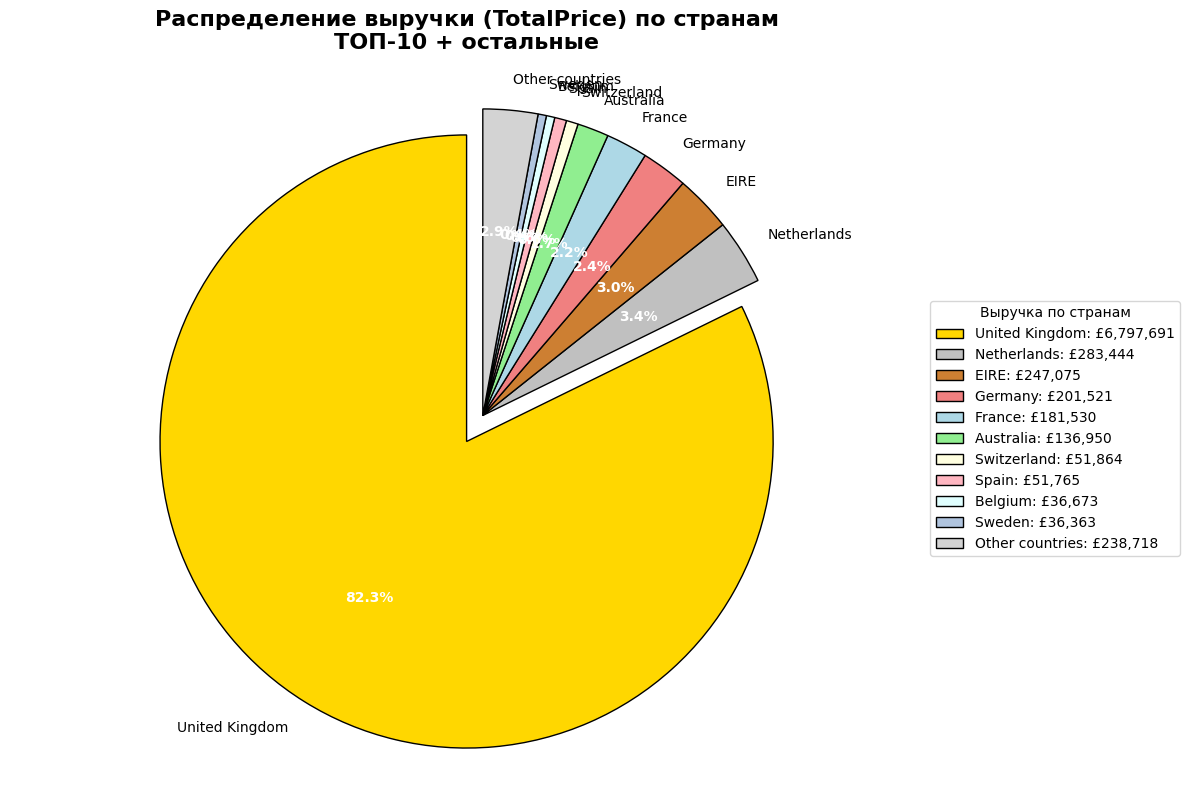

СТАТИСТИКА ВЫРУЧКИ ПО СТРАНАМ:
Общая выручка: £8,263,592.99

ТОП-5 стран по выручке:
1. United Kingdom      : £6,797,691.44 ( 82.3%)
2. Netherlands         : £  283,443.54 (  3.4%)
3. EIRE                : £  247,074.57 (  3.0%)
4. Germany             : £  201,520.71 (  2.4%)
5. France              : £  181,529.63 (  2.2%)


In [54]:
# Круговая диаграмма по выручке (TotalPrice) по странам
import matplotlib.pyplot as plt

# Рассчитаем общую выручку по каждой стране
revenue_by_country = data.groupby('Country')['TotalPrice'].sum().reset_index()
revenue_by_country = revenue_by_country.sort_values('TotalPrice', ascending=False)

# Возьмем топ-10 стран для лучшей читаемости диаграммы
top_countries = revenue_by_country.head(10)
other_revenue = revenue_by_country.iloc[10:]['TotalPrice'].sum()

# Подготовим данные для pie chart
countries = top_countries['Country'].tolist()
revenues = top_countries['TotalPrice'].tolist()

# Добавим "Other countries" если есть остальные
if other_revenue > 0:
    countries.append('Other countries')
    revenues.append(other_revenue)

# Создаем pie chart
plt.figure(figsize=(12, 8))

# Определяем цвета - выделим ТОП-3
colors = ['gold', 'silver', '#CD7F32', 'lightcoral', 'lightblue', 
          'lightgreen', 'lightyellow', 'lightpink', 'lightcyan', 
          'lightsteelblue', 'lightgray']

# Взрываем (выделяем) сегмент с максимальной выручкой
explode = [0.1 if i == 0 else 0 for i in range(len(countries))]

wedges, texts, autotexts = plt.pie(revenues, labels=countries, colors=colors[:len(countries)], 
                                   autopct='%1.1f%%', startangle=90, explode=explode)

# Настройка внешнего вида
plt.title('Распределение выручки (TotalPrice) по странам\nТОП-10 + остальные', 
          fontsize=16, fontweight='bold', pad=20)

# Улучшаем читаемость процентов
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Добавляем легенду с точными значениями
legend_labels = [f"{country}: £{revenue:,.0f}" for country, revenue in zip(countries, revenues)]
plt.legend(wedges, legend_labels, title="Выручка по странам", 
          loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')  # Чтобы круг был круглым
plt.tight_layout()
plt.show()

# Выведем дополнительную статистику
print("СТАТИСТИКА ВЫРУЧКИ ПО СТРАНАМ:")
print("=" * 50)
total_revenue = revenue_by_country['TotalPrice'].sum()
print(f"Общая выручка: £{total_revenue:,.2f}")
print(f"\nТОП-5 стран по выручке:")
for i, (idx, row) in enumerate(top_countries.head(5).iterrows(), 1):
    percentage = (row['TotalPrice'] / total_revenue) * 100
    print(f"{i}. {row['Country']:20}: £{row['TotalPrice']:12,.2f} ({percentage:5.1f}%)")

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

- month: месяц (1-12)
- day_of_week: день недели (0=понедельник, 6=воскресенье)
- hour: час (0-23)
Самый прибыльный месяц: Ноябрь (№11)
Выручка: £1,119,641.60


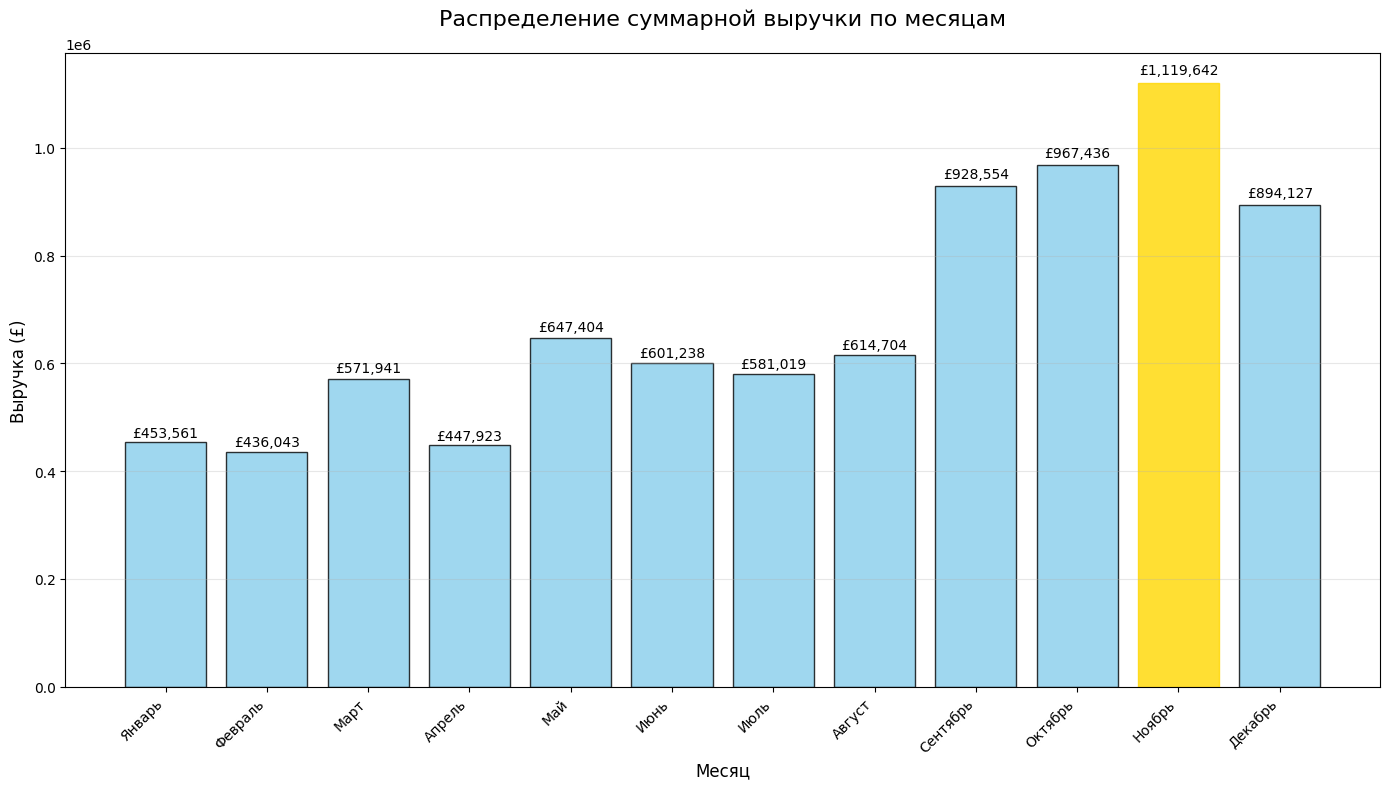


Суммарная выручка по месяцам:
Month_Name       Revenue
    Январь   £453,560.68
   Февраль   £436,043.09
      Март   £571,941.01
    Апрель   £447,922.86
       Май   £647,403.81
      Июнь   £601,238.45
      Июль   £581,019.35
    Август   £614,704.38
  Сентябрь   £928,554.44
   Октябрь   £967,436.46
    Ноябрь £1,119,641.60
   Декабрь   £894,126.86


In [55]:
# Создаем признаки времени из InvoiceDate
print(f"- month: месяц (1-12)")
print(f"- day_of_week: день недели (0=понедельник, 6=воскресенье)")
print(f"- hour: час (0-23)")
data['month'] = data['InvoiceDate'].dt.month
data['day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['hour'] = data['InvoiceDate'].dt.hour

# Построим визуализацию распределения суммарной выручки по месяцам

# Группируем данные по месяцам и считаем суммарную выручку
revenue_by_month = data.groupby('month')['TotalPrice'].sum().reset_index()
revenue_by_month.columns = ['Month', 'Revenue']

# Создаем названия месяцев
month_names = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 
               5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август',
               9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'}

revenue_by_month['Month_Name'] = revenue_by_month['Month'].map(month_names)

# Находим самый прибыльный месяц
most_profitable_month = revenue_by_month.loc[revenue_by_month['Revenue'].idxmax()]
print(f"Самый прибыльный месяц: {most_profitable_month['Month_Name']} (№{most_profitable_month['Month']})")
print(f"Выручка: £{most_profitable_month['Revenue']:,.2f}")

# Создаем визуализацию
plt.figure(figsize=(14, 8))
bars = plt.bar(revenue_by_month['Month_Name'], revenue_by_month['Revenue'], 
               color='skyblue', alpha=0.8, edgecolor='black', linewidth=1)

# Выделяем самый прибыльный месяц
max_month_idx = revenue_by_month['Revenue'].idxmax()
bars[max_month_idx].set_color('gold')

plt.title('Распределение суммарной выручки по месяцам', fontsize=16, pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Выручка (£)', fontsize=12)

# Поворачиваем подписи по оси X
plt.xticks(rotation=45, ha='right')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'£{height:,.0f}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Выводим таблицу с данными
print("\nСуммарная выручка по месяцам:")
print(revenue_by_month[['Month_Name', 'Revenue']].to_string(index=False, 
                                                            formatters={'Revenue': '£{:,.2f}'.format}))

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье



Полная статистика по всем дням недели:
Понедельник: 2830 заказов
Вторник: 3156 заказов
Среда: 3436 заказов
Четверг: 4003 заказов
Пятница: 2809 заказов
Суббота: 0 заказов
Воскресенье: 2168 заказов


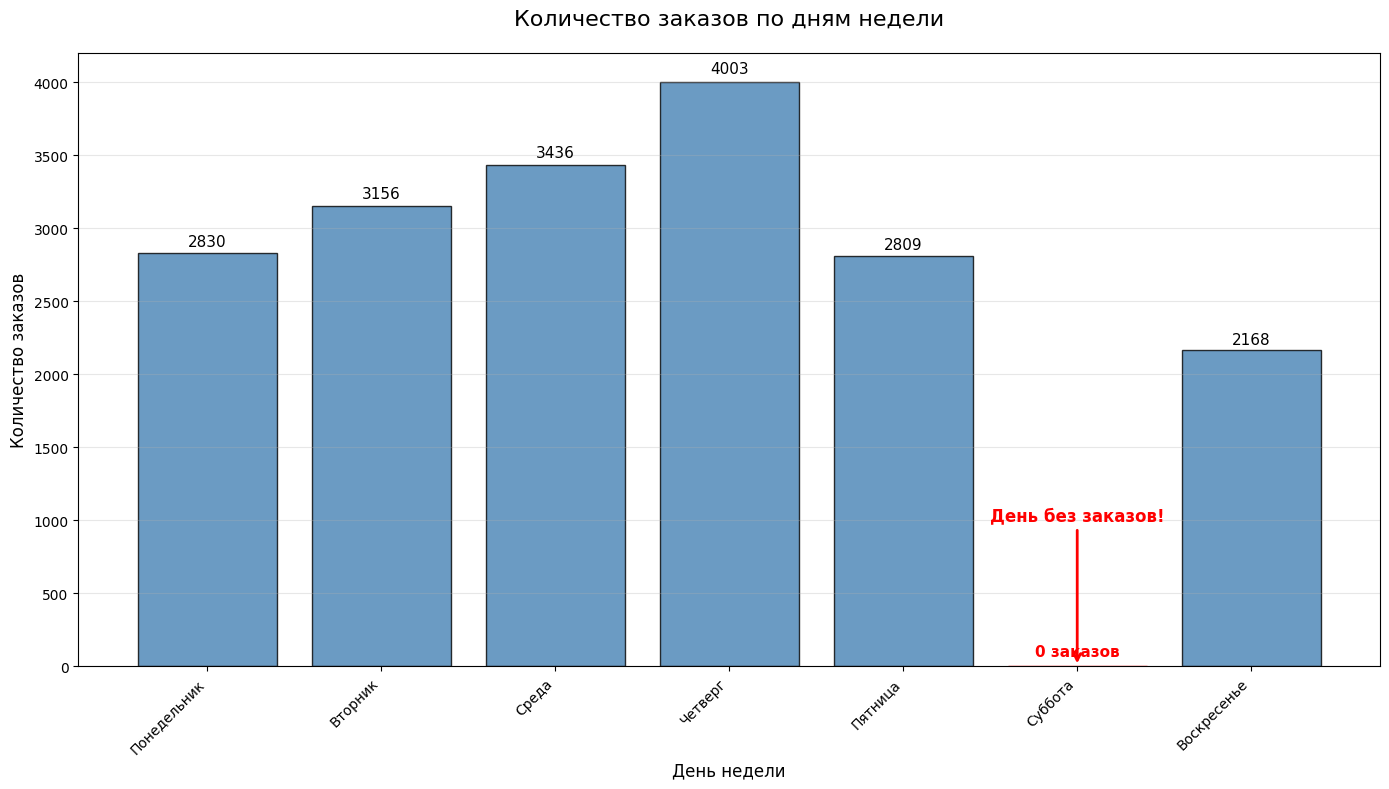

In [57]:
# Анализируем количество заказов по дням недели

# Группируем данные по дням недели и считаем количество заказов (уникальных InvoiceNo)
orders_by_weekday = data.groupby('day_of_week')['InvoiceNo'].nunique().reset_index()
orders_by_weekday.columns = ['WeekDay', 'Orders']

# Создаем названия дней недели (0=понедельник, 6=воскресенье)
weekday_names = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
                 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

orders_by_weekday['WeekDay_Name'] = orders_by_weekday['WeekDay'].map(weekday_names)

# Создаем полную таблицу с все днями недели (включая отсутствующие)
full_weekdays = pd.DataFrame({'WeekDay': list(range(7))})
full_weekdays['WeekDay_Name'] = full_weekdays['WeekDay'].map(weekday_names)
orders_full = full_weekdays.merge(orders_by_weekday, on='WeekDay', how='left')
orders_full['Orders'] = orders_full['Orders'].fillna(0)
orders_full['WeekDay_Name'] = orders_full['WeekDay_Name_x']

print(f"\nПолная статистика по всем дням недели:")
for _, row in orders_full.iterrows():
    print(f"{row['WeekDay_Name']}: {int(row['Orders'])} заказов")
    
# Создаем визуализацию количества заказов по дням недели

plt.figure(figsize=(14, 8))

# Используем полную таблицу с нулевыми значениями для субботы
colors = ['lightcoral' if orders == 0 else 'steelblue' for orders in orders_full['Orders']]

bars = plt.bar(orders_full['WeekDay_Name'], orders_full['Orders'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Выделяем субботу (день без заказов) красным цветом
for i, (bar, orders) in enumerate(zip(bars, orders_full['Orders'])):
    if orders == 0:
        bar.set_color('red')
        bar.set_alpha(1.0)
    
    # Добавляем значения на столбцы
    height = bar.get_height()
    if height == 0:
        plt.text(bar.get_x() + bar.get_width()/2., 50,  # Поднимаем текст для видимости
                 '0 заказов',
                 ha='center', va='bottom', fontsize=11, 
                 color='red', weight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=11)

plt.title('Количество заказов по дням недели', fontsize=16, pad=20)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)

# Поворачиваем подписи по оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Добавляем сетку для лучшего восприятия
plt.grid(axis='y', alpha=0.3)

# Добавляем аннотацию для дня без заказов
plt.annotate('День без заказов!', 
             xy=(5, 0), xytext=(5, 1000),  # суббота имеет индекс 5
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=12, color='red', weight='bold',
             ha='center')

plt.tight_layout()
plt.show()

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня



Среднее количество заказов по часам:
Час 06:00 - 1.0 заказов в среднем
Час 07:00 - 1.3 заказов в среднем
Час 08:00 - 2.7 заказов в среднем
Час 09:00 - 5.5 заказов в среднем
Час 10:00 - 7.3 заказов в среднем
Час 11:00 - 7.4 заказов в среднем
Час 12:00 - 10.2 заказов в среднем
Час 13:00 - 8.7 заказов в среднем
Час 14:00 - 7.5 заказов в среднем
Час 15:00 - 6.7 заказов в среднем
Час 16:00 - 4.1 заказов в среднем
Час 17:00 - 2.9 заказов в среднем
Час 18:00 - 3.6 заказов в среднем
Час 19:00 - 2.9 заказов в среднем
Час 20:00 - 1.3 заказов в среднем

Рабочее время: с 6:00 до 20:00
В ночные часы (21:00 - 05:59) заказов нет


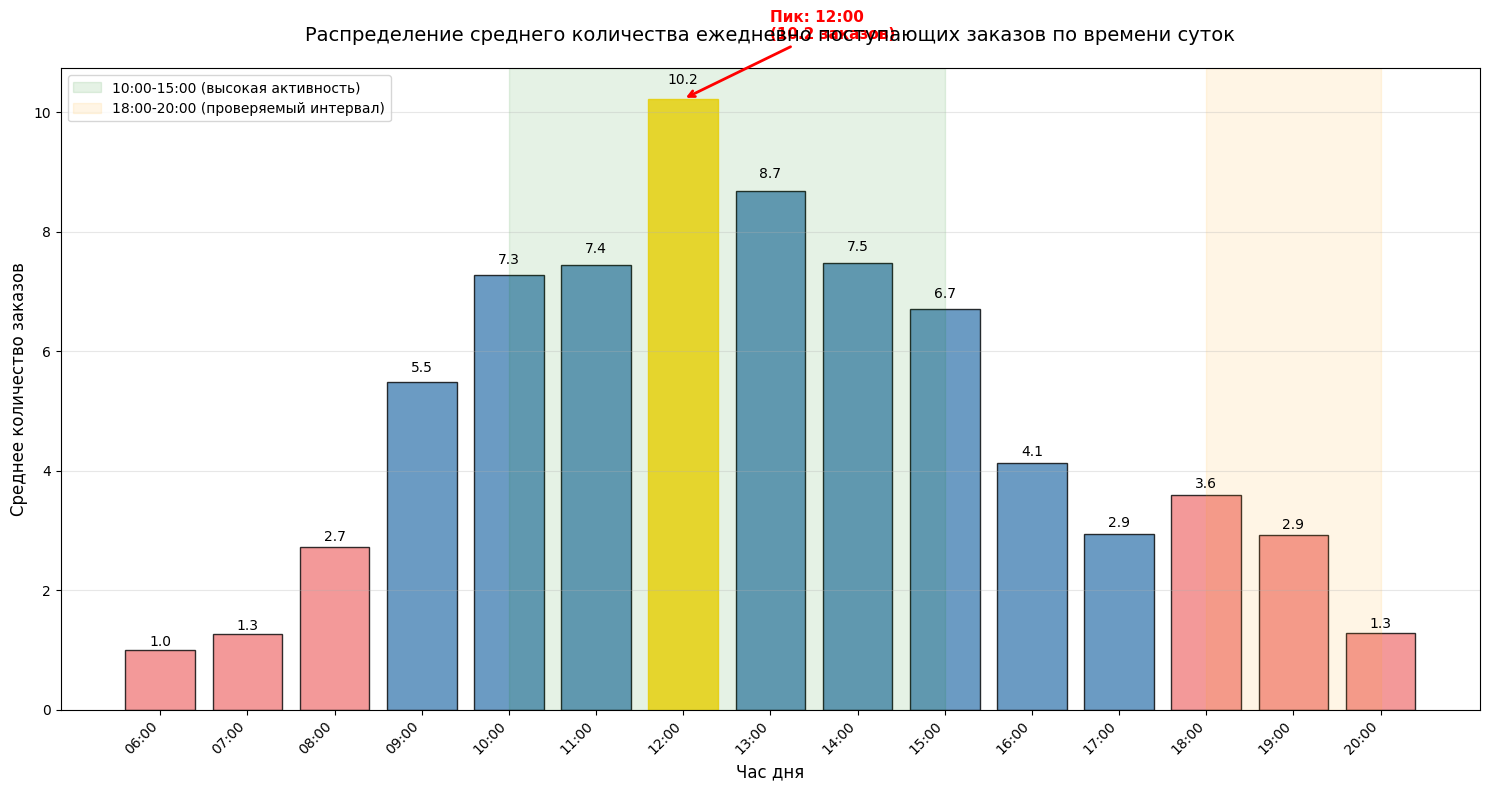

In [59]:
# Задание 4.7: Анализ заказов по дате и времени

# 1. Выделяем дату из InvoiceDate
data['date'] = data['InvoiceDate'].dt.date

# 2. Группируем данные по датам и часам, считаем количество заказов
orders_by_date_hour = data.groupby(['date', 'hour'])['InvoiceNo'].nunique().reset_index()
orders_by_date_hour.columns = ['Date', 'Hour', 'Orders']

# 3. Находим среднее количество ежедневно поступающих заказов в каждый час
avg_orders_by_hour = orders_by_date_hour.groupby('Hour')['Orders'].mean().reset_index()
avg_orders_by_hour.columns = ['Hour', 'Avg_Orders']

print("\nСреднее количество заказов по часам:")
for _, row in avg_orders_by_hour.iterrows():
    print(f"Час {int(row['Hour']):02d}:00 - {row['Avg_Orders']:.1f} заказов в среднем")

# Проверим диапазон рабочих часов
min_hour = data['hour'].min()
max_hour = data['hour'].max()
print(f"\nРабочее время: с {min_hour}:00 до {max_hour}:00")

# Проверим, есть ли заказы в ночные часы (21-06)
night_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5]
night_data = data[data['hour'].isin(night_hours)]
if len(night_data) == 0:
    print("В ночные часы (21:00 - 05:59) заказов нет")
else:
    print(f"В ночные часы найдено {len(night_data)} транзакций")


# Построим визуализацию распределения заказов по времени суток

plt.figure(figsize=(15, 8))

# Создаем столбчатую диаграмму
colors = ['lightcoral' if hour < 9 or hour > 17 else 'steelblue' for hour in avg_orders_by_hour['Hour']]
bars = plt.bar(avg_orders_by_hour['Hour'], avg_orders_by_hour['Avg_Orders'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Выделяем пиковые часы (12:00 - максимум)
max_hour_idx = avg_orders_by_hour['Avg_Orders'].idxmax()
max_hour = avg_orders_by_hour.loc[max_hour_idx, 'Hour']
max_orders = avg_orders_by_hour.loc[max_hour_idx, 'Avg_Orders']
bars[max_hour_idx].set_color('gold')

# Добавляем значения на столбцы
for i, (bar, avg_orders) in enumerate(zip(bars, avg_orders_by_hour['Avg_Orders'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
             f'{avg_orders:.1f}',
             ha='center', va='bottom', fontsize=10)

plt.title('Распределение среднего количества ежедневно поступающих заказов по времени суток', fontsize=14, pad=20)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)

# Настраиваем оси
plt.xticks(range(6, 21), [f'{h:02d}:00' for h in range(6, 21)], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Добавляем аннотации для анализа
plt.annotate(f'Пик: {max_hour:02.0f}:00\n({max_orders:.1f} заказов)', 
             xy=(max_hour, max_orders), xytext=(max_hour+1, max_orders+1),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, color='red', weight='bold')

# Выделим интервалы для анализа
plt.axvspan(10, 15, alpha=0.1, color='green', label='10:00-15:00 (высокая активность)')
plt.axvspan(18, 20, alpha=0.1, color='orange', label='18:00-20:00 (проверяемый интервал)')

plt.legend()
plt.tight_layout()
plt.show()




## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

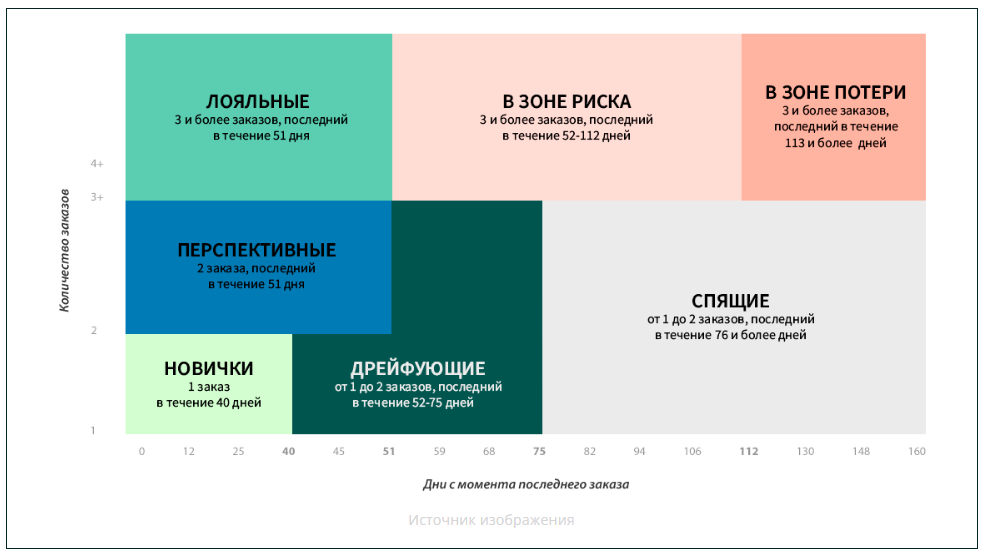

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [66]:
# Задание 5.1: Создание RFM-таблицы

# Определяем точку отсчета t0 - 10 декабря 2011 года
t0 = pd.to_datetime('2011-12-10 00:00:00')
print(f"Точка отсчета t0: {t0}")

# Создаем RFM-таблицу
# Группируем данные по CustomerID и рассчитываем метрики
rfm_table = data.groupby('CustomerID').agg({
    'InvoiceDate': 'max',        # Для расчета Recency - последняя дата заказа
    'InvoiceNo': 'nunique',      # Для Frequency - количество уникальных заказов
    'TotalPrice': 'sum'          # Для Monetary Value - общая сумма покупок
}).reset_index()

# Переименовываем столбцы для ясности
rfm_table.columns = ['CustomerID', 'LastOrderDate', 'Frequency', 'MonetaryValue']

# Рассчитываем Recency - количество дней от последнего заказа до точки отсчета
rfm_table['Recency'] = (t0 - rfm_table['LastOrderDate']).dt.days

# Перестраиваем порядок столбцов для RFM-таблицы
rfm_table = rfm_table[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']]

print(f"RFM-таблица создана для {len(rfm_table)} клиентов")
print("\nПервые 5 строк RFM-таблицы:")
print(rfm_table.head(5))

Точка отсчета t0: 2011-12-10 00:00:00
RFM-таблица создана для 4334 клиентов

Первые 5 строк RFM-таблицы:
  CustomerID  Recency  Frequency  MonetaryValue
0      12346      325          1           0.00
1      12347        2          7        4310.00
2      12348       75          4        1437.24
3      12349       18          1        1457.55
4      12350      310          1         294.40


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [67]:
# 1) Сколько клиентов совершили покупку более 200 дней назад?
clients_more_200_days = rfm_table[rfm_table['Recency'] > 200]
answer_1 = len(clients_more_200_days)

print(f"1) Количество клиентов, совершивших покупку более 200 дней назад: {answer_1}")

# 2) Сколько заказов в среднем делает клиент (округлено до целого)?
average_orders = rfm_table['Frequency'].mean()
answer_2 = round(average_orders)

print(f"2) Среднее количество заказов на клиента: {answer_2} заказов")
print(f"   (точное значение: {average_orders:.2f})")

# 3) Общая сумма денег клиента с идентификатором 12360
# Нужно проверить с учетом того, что ID хранятся как строки
client_12360 = rfm_table[rfm_table['CustomerID'] == '12360']
if len(client_12360) > 0:
    answer_3 = round(client_12360['MonetaryValue'].iloc[0])
    print(f"3) Общая сумма денег клиента 12360: £{answer_3}")
    print(f"   (точное значение: £{client_12360['MonetaryValue'].iloc[0]:.2f})")
else:
    # Проверим числовое значение, если строковое не найдено
    client_12360_num = rfm_table[rfm_table['CustomerID'] == 12360]
    if len(client_12360_num) > 0:
        answer_3 = round(client_12360_num['MonetaryValue'].iloc[0])
        print(f"3) Общая сумма денег клиента 12360: £{answer_3}")
        print(f"   (точное значение: £{client_12360_num['MonetaryValue'].iloc[0]:.2f})")
    else:
        print("3) Клиент с идентификатором 12360 не найден в RFM-таблице")
        answer_3 = 0

1) Количество клиентов, совершивших покупку более 200 дней назад: 743
2) Среднее количество заказов на клиента: 4 заказов
   (точное значение: 4.25)
3) Общая сумма денег клиента 12360: £2302
   (точное значение: £2302.06)


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [69]:
# Исключаем CustomerID из боксплотов, так как это не числовые данные для анализа
numeric_columns = ['Recency', 'Frequency', 'MonetaryValue']
boxes = [px.box(rfm_table, y=column) for column in numeric_columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# Создаем директорию для сохранения HTML файлов, если она не существует
import os
os.makedirs('plotly', exist_ok=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

frequency >frequency_{0.95}
monetary >monetary_{0.95}

где frequency_{0.95} и monetary_{0.95} - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [70]:
# Задание 5.2: Удаление выбросов по квантилю 0.95

# Вычисляем квантили 0.95 для Frequency и MonetaryValue
frequency_095 = rfm_table['Frequency'].quantile(0.95)
monetary_095 = rfm_table['MonetaryValue'].quantile(0.95)

print(f"Квантиль 0.95 для Frequency: {frequency_095}")
print(f"Квантиль 0.95 для MonetaryValue: {monetary_095:.2f}")

# Отфильтровываем клиентов, удаляя тех, у кого frequency > frequency_0.95 ИЛИ monetary > monetary_0.95
rfm_table_filtered = rfm_table[
    (rfm_table['Frequency'] <= frequency_095) & 
    (rfm_table['MonetaryValue'] <= monetary_095)
]

print(f"\nРазмер RFM-таблицы после фильтрации: {rfm_table_filtered.shape[0]}")
print(f"Удалено клиентов: {rfm_table.shape[0] - rfm_table_filtered.shape[0]}")

# Обновляем основную таблицу
rfm_table = rfm_table_filtered.copy()

print(f"\nОкончательный размер RFM-таблицы: {rfm_table.shape[0]}")

Квантиль 0.95 для Frequency: 13.0
Квантиль 0.95 для MonetaryValue: 5659.85

Размер RFM-таблицы после фильтрации: 4044
Удалено клиентов: 290

Окончательный размер RFM-таблицы: 4044


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [71]:
# Создаем боксплоты для очищенной от выбросов RFM-таблицы
numeric_columns = ['Recency', 'Frequency', 'MonetaryValue']
boxes = [px.box(rfm_table, y=column) for column in numeric_columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


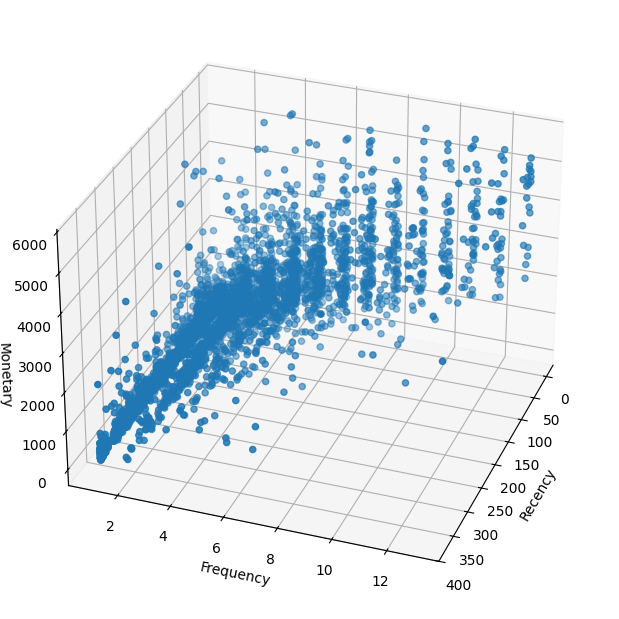

In [72]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table['Recency'].to_list(), 
    rfm_table['Frequency'].to_list(),
    rfm_table['MonetaryValue'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [73]:
# Задание 5.3: Создание pipeline с StandardScaler и PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Создаем pipeline с StandardScaler и PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Подготавливаем данные для анализа (только числовые столбцы RFM)
rfm_data = rfm_table[['Recency', 'Frequency', 'MonetaryValue']]

# Обучаем pipeline на очищенной RFM-таблице
pipeline.fit(rfm_data)

# Применяем трансформацию
rfm_transformed = pipeline.transform(rfm_data)

# Получаем долю объясненной дисперсии для каждой компоненты
explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_

print(f"\nДоля дисперсии, объясняемая каждой компонентой:")
print(f"Первая главная компонента: {explained_variance_ratio[0]:.4f}")
print(f"Вторая главная компонента: {explained_variance_ratio[1]:.4f}")
print(f"Общая доля объясненной дисперсии: {explained_variance_ratio.sum():.4f}")

# Ответ на вопрос задания (округлен до двух знаков после запятой)
first_component_variance = round(explained_variance_ratio[0], 2)
print(f"\nОтвет: Первая главная компонента объясняет {first_component_variance} дисперсии исходных данных")

# Создаем DataFrame с преобразованными данными для дальнейшего анализа
rfm_table_processed = pd.DataFrame(rfm_transformed, columns=['axis-1', 'axis-2'])
rfm_table_processed['CustomerID'] = rfm_table['CustomerID'].values

print(rfm_table_processed.head(5))


Доля дисперсии, объясняемая каждой компонентой:
Первая главная компонента: 0.6775
Вторая главная компонента: 0.2401
Общая доля объясненной дисперсии: 0.9176

Ответ: Первая главная компонента объясняет 0.68 дисперсии исходных данных
     axis-1    axis-2 CustomerID
0 -2.135201  1.401596      12346
1  3.447125  0.852872      12347
2  0.629103  0.083217      12348
3  0.152932 -0.720954      12349
4 -1.888765  1.382645      12350


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

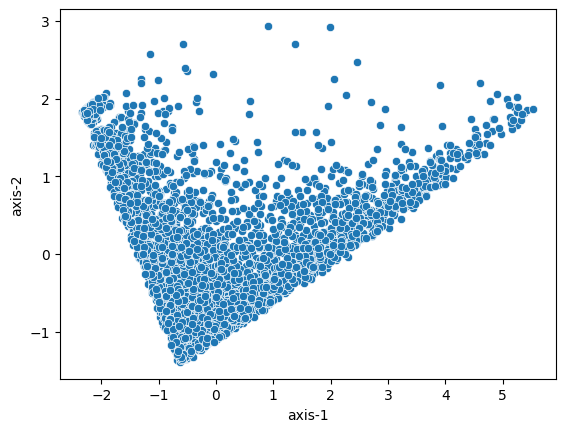

In [74]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



Подбор оптимального количества кластеров (k от 2 до 10):
k	Silhouette Score
-------------------------
2	0.5002
3	0.5241
4	0.4976
5	0.4491
6	0.4480
7	0.4455
8	0.4244
9	0.4223
10	0.4130

Результаты:
Оптимальное количество кластеров: 3
Максимальный коэффициент силуэта: 0.5241
Максимальный коэффициент силуэта (округлен до 2 знаков): 0.52


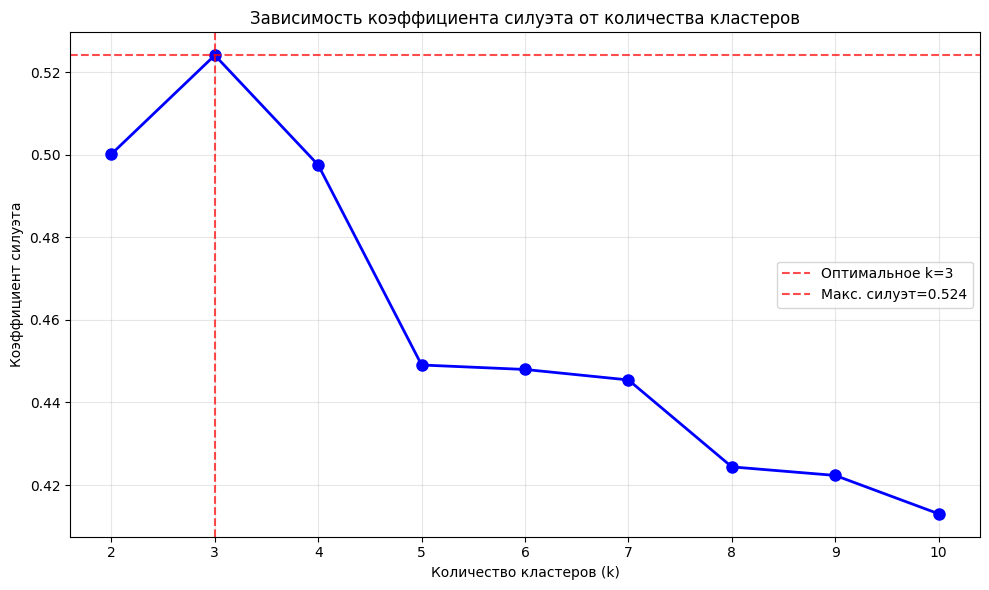


Ответы на вопросы задания:
1) Оптимальное количество кластеров: 3
2) Максимальное значение коэффициента силуэта: 0.52


In [76]:
# Задание 5.4: Подбор оптимального количества кластеров с помощью коэффициента силуэта

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Используем преобразованные данные после PCA
X = rfm_table_processed[['axis-1', 'axis-2']]

# Создаем список для хранения результатов
k_range = range(2, 11)  # от 2 до 10 включительно
silhouette_scores = []
k_values = []

print(f"\nПодбор оптимального количества кластеров (k от {min(k_range)} до {max(k_range)}):")
print("k\tSilhouette Score")
print("-" * 25)

# Перебираем количество кластеров и вычисляем коэффициент силуэта
for k in k_range:
    # Создаем модель KMeans с random_state=42
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Обучаем модель
    cluster_labels = kmeans.fit_predict(X)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Сохраняем результаты
    k_values.append(k)
    silhouette_scores.append(silhouette_avg)
    
    print(f"{k}\t{silhouette_avg:.4f}")

# Находим оптимальное количество кластеров
max_silhouette_score = max(silhouette_scores)
optimal_k = k_values[silhouette_scores.index(max_silhouette_score)]

print(f"\nРезультаты:")
print(f"Оптимальное количество кластеров: {optimal_k}")
print(f"Максимальный коэффициент силуэта: {max_silhouette_score:.4f}")
print(f"Максимальный коэффициент силуэта (округлен до 2 знаков): {round(max_silhouette_score, 2)}")

# Строим график коэффициента силуэта
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.title('Зависимость коэффициента силуэта от количества кластеров')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Отмечаем максимальное значение
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Оптимальное k={optimal_k}')
plt.axhline(y=max_silhouette_score, color='red', linestyle='--', alpha=0.7, label=f'Макс. силуэт={max_silhouette_score:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nОтветы на вопросы задания:")
print(f"1) Оптимальное количество кластеров: {optimal_k}")
print(f"2) Максимальное значение коэффициента силуэта: {round(max_silhouette_score, 2)}")

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



Подбор оптимального количества кластеров для EM-алгоритма (k от 2 до 10):
k	Silhouette Score (EM)
------------------------------
2	0.3425
3	0.4358
4	0.3501
5	0.2797
6	0.2726
7	0.2366
8	0.1952
9	0.1624
10	0.1452

Результаты для EM-алгоритма:
Оптимальное количество кластеров: 3
Максимальный коэффициент силуэта: 0.4358
Максимальный коэффициент силуэта (округлен до 2 знаков): 0.44

Сравнение методов:
Метод           Опт. k   Макс. силуэт   
----------------------------------------
K-Means         3        0.5241
EM (GMM)        3        0.4358


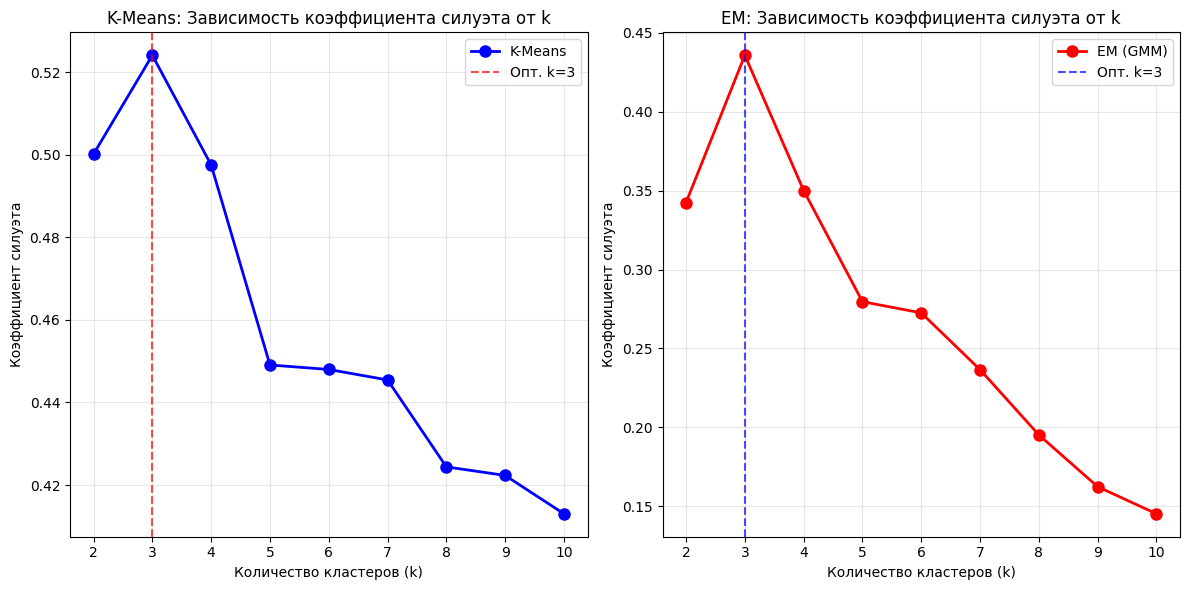


Ответы на вопросы задания 5.5:
1) Оптимальное количество кластеров для EM-алгоритма: 3
2) Максимальное значение коэффициента силуэта: 0.44


In [77]:
# Задание 5.5: Подбор оптимального количества кластеров с помощью EM-алгоритма (GaussianMixture)

from sklearn.mixture import GaussianMixture

# Используем те же данные после PCA
X = rfm_table_processed[['axis-1', 'axis-2']]

# Создаем списки для хранения результатов
k_range_em = range(2, 11)  # от 2 до 10 включительно
silhouette_scores_em = []
k_values_em = []

print(f"\nПодбор оптимального количества кластеров для EM-алгоритма (k от {min(k_range_em)} до {max(k_range_em)}):")
print("k\tSilhouette Score (EM)")
print("-" * 30)

# Перебираем количество кластеров и вычисляем коэффициент силуэта для GaussianMixture
for k in k_range_em:
    # Создаем модель GaussianMixture с random_state=42
    gmm = GaussianMixture(n_components=k, random_state=42)
    
    # Обучаем модель и получаем предсказания
    cluster_labels_em = gmm.fit_predict(X)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg_em = silhouette_score(X, cluster_labels_em)
    
    # Сохраняем результаты
    k_values_em.append(k)
    silhouette_scores_em.append(silhouette_avg_em)
    
    print(f"{k}\t{silhouette_avg_em:.4f}")

# Находим оптимальное количество кластеров для EM-алгоритма
max_silhouette_score_em = max(silhouette_scores_em)
optimal_k_em = k_values_em[silhouette_scores_em.index(max_silhouette_score_em)]

print(f"\nРезультаты для EM-алгоритма:")
print(f"Оптимальное количество кластеров: {optimal_k_em}")
print(f"Максимальный коэффициент силуэта: {max_silhouette_score_em:.4f}")
print(f"Максимальный коэффициент силуэта (округлен до 2 знаков): {round(max_silhouette_score_em, 2)}")

# Создаем сравнительную таблицу K-Means vs EM
print(f"\nСравнение методов:")
print(f"{'Метод':<15} {'Опт. k':<8} {'Макс. силуэт':<15}")
print("-" * 40)
print(f"{'K-Means':<15} {optimal_k:<8} {max_silhouette_score:.4f}")
print(f"{'EM (GMM)':<15} {optimal_k_em:<8} {max_silhouette_score_em:.4f}")

# Строим сравнительный график
plt.figure(figsize=(12, 6))

# K-Means
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8, label='K-Means')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.title('K-Means: Зависимость коэффициента силуэта от k')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Опт. k={optimal_k}')
plt.legend()

# EM (GaussianMixture)
plt.subplot(1, 2, 2)
plt.plot(k_values_em, silhouette_scores_em, 'ro-', linewidth=2, markersize=8, label='EM (GMM)')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.title('EM: Зависимость коэффициента силуэта от k')
plt.grid(True, alpha=0.3)
plt.xticks(k_values_em)
plt.axvline(x=optimal_k_em, color='blue', linestyle='--', alpha=0.7, label=f'Опт. k={optimal_k_em}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nОтветы на вопросы задания 5.5:")
print(f"1) Оптимальное количество кластеров для EM-алгоритма: {optimal_k_em}")
print(f"2) Максимальное значение коэффициента силуэта: {round(max_silhouette_score_em, 2)}")

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [80]:
# 2) Обучение лучшей модели и анализ распределения кластеров

X = rfm_table_processed[['axis-1', 'axis-2']]

# Обучаем K-Means с оптимальным количеством кластеров
best_model = KMeans(n_clusters=3, random_state=42)
cluster_labels_best = best_model.fit_predict(X)

# Анализируем распределение кластеров
import numpy as np
from collections import Counter

# Подсчитываем количество клиентов в каждом кластере
cluster_counts = Counter(cluster_labels_best)
cluster_distribution = dict(sorted(cluster_counts.items()))

print(f"\nРаспределение клиентов по кластерам:")
print(f"{'Кластер':<10} {'Количество':<12} {'Процент':<10}")
print("-" * 35)

total_clients = len(cluster_labels_best)
for cluster_id, count in cluster_distribution.items():
    percentage = (count / total_clients) * 100
    print(f"{cluster_id:<10} {count:<12} {percentage:.1f}%")

# Находим самый большой кластер
largest_cluster_id = max(cluster_distribution, key=cluster_distribution.get)
largest_cluster_size = cluster_distribution[largest_cluster_id]
largest_cluster_percent = (largest_cluster_size / total_clients) * 100


print(f"\nСАМЫЙ БОЛЬШОЙ КЛАСТЕР:")
print(f"   Кластер №: {largest_cluster_id}")
print(f"   Количество клиентов: {largest_cluster_size}")
print(f"   Процент от общего числа: {largest_cluster_percent:.1f}%")

# Добавляем метки кластеров к исходным данным для дальнейшего анализа
rfm_table_processed['cluster'] = cluster_labels_best



Распределение клиентов по кластерам:
Кластер    Количество   Процент   
-----------------------------------
0          773          19.1%
1          1001         24.8%
2          2270         56.1%

САМЫЙ БОЛЬШОЙ КЛАСТЕР:
   Кластер №: 2
   Количество клиентов: 2270
   Процент от общего числа: 56.1%


Визуализируем результаты кластеризации:

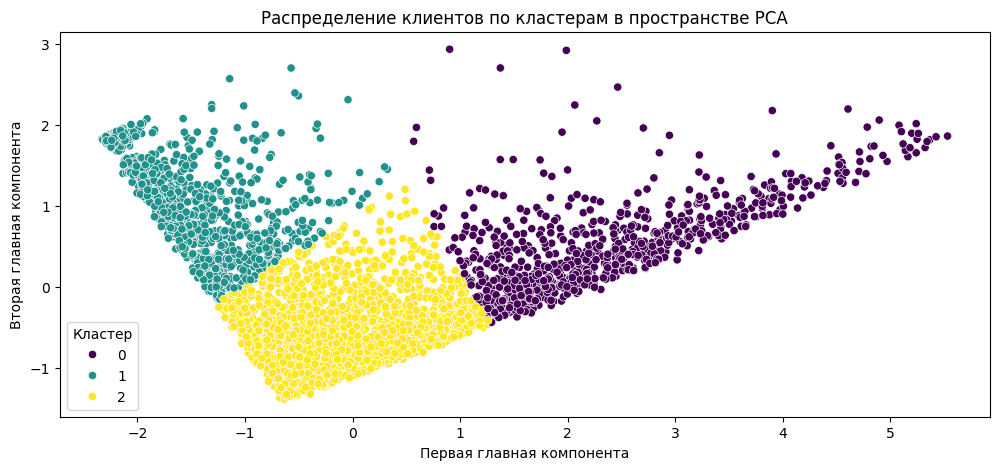

In [82]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='cluster',
    palette='viridis'
);
plt.title('Распределение клиентов по кластерам в пространстве PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.legend(title='Кластер')
plt.show()

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [85]:
# Задание 5.7: Создание профиля кластеров

# Добавляем кластерные метки к очищенной RFM-таблице
rfm_with_clusters = rfm_table_filtered.copy()
rfm_with_clusters['cluster'] = cluster_labels_best

print("RFM таблица с кластерами:")
print(rfm_with_clusters.head())

# Группируем по кластерам и рассчитываем средние значения
cluster_profiles = rfm_with_clusters.groupby('cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean()

print("\nПрофили кластеров (средние значения):")
print(cluster_profiles)

# Находим максимальное среднее значение признака Frequency
max_frequency_mean = cluster_profiles['Frequency'].max()
print(f"\nМаксимальное среднее значение Frequency: {max_frequency_mean}")

RFM таблица с кластерами:
  CustomerID  Recency  Frequency  MonetaryValue  cluster
0      12346      325          1           0.00        1
1      12347        2          7        4310.00        0
2      12348       75          4        1437.24        2
3      12349       18          1        1457.55        2
4      12350      310          1         294.40        1

Профили кластеров (средние значения):
            Recency  Frequency  MonetaryValue
cluster                                      
0         32.010349   7.076326    2662.157012
1        253.283716   1.405594     386.598472
2         51.079295   2.332599     661.306912

Максимальное среднее значение Frequency: 7.076326002587322


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [87]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [88]:
# Apply plot_cluster_profile function to cluster_profiles with n_clusters=3
print("Cluster profiles data:")
print(cluster_profiles)
print()

# Create the polar radar chart for cluster profiles
print("Generating polar diagram for cluster profiles...")
plot_cluster_profile(cluster_profiles, n_clusters=3)

Cluster profiles data:
            Recency  Frequency  MonetaryValue
cluster                                      
0         32.010349   7.076326    2662.157012
1        253.283716   1.405594     386.598472
2         51.079295   2.332599     661.306912

Generating polar diagram for cluster profiles...


### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [91]:
# Конвертируем CustomerID в индекс для правильного обучения t-SNE
print("\nКОНВЕРТАЦИЯ CustomerID В ИНДЕКС")
if 'CustomerID' in rfm_table_filtered.columns:
    # Создаем датафрейм с CustomerID как индексом (только RFM признаки для обучения)
    rfm_for_tsne = rfm_table_filtered.set_index('CustomerID')
    print(f"Размерность для обучения: {rfm_for_tsne.shape}")
    print(f"Признаки для t-SNE: {list(rfm_for_tsne.columns)}")
    print("\nПервые 3 строки:")
    display(rfm_for_tsne.head(3))
else:
    print("CustomerID уже является индексом")
    rfm_for_tsne = rfm_table_filtered


КОНВЕРТАЦИЯ CustomerID В ИНДЕКС
Размерность для обучения: (4044, 3)
Признаки для t-SNE: ['Recency', 'Frequency', 'MonetaryValue']

Первые 3 строки:


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24


Первые 5 строк преобразованных данных:
[[ -5.1379786  32.757576 ]
 [ 19.764296   29.50897  ]
 [ 30.546396   -2.0824075]
 [  9.11008   -19.65887  ]
 [ -8.596581   27.242176 ]]
Дивергенция Кульбака-Лейблера: 0.5414804816246033


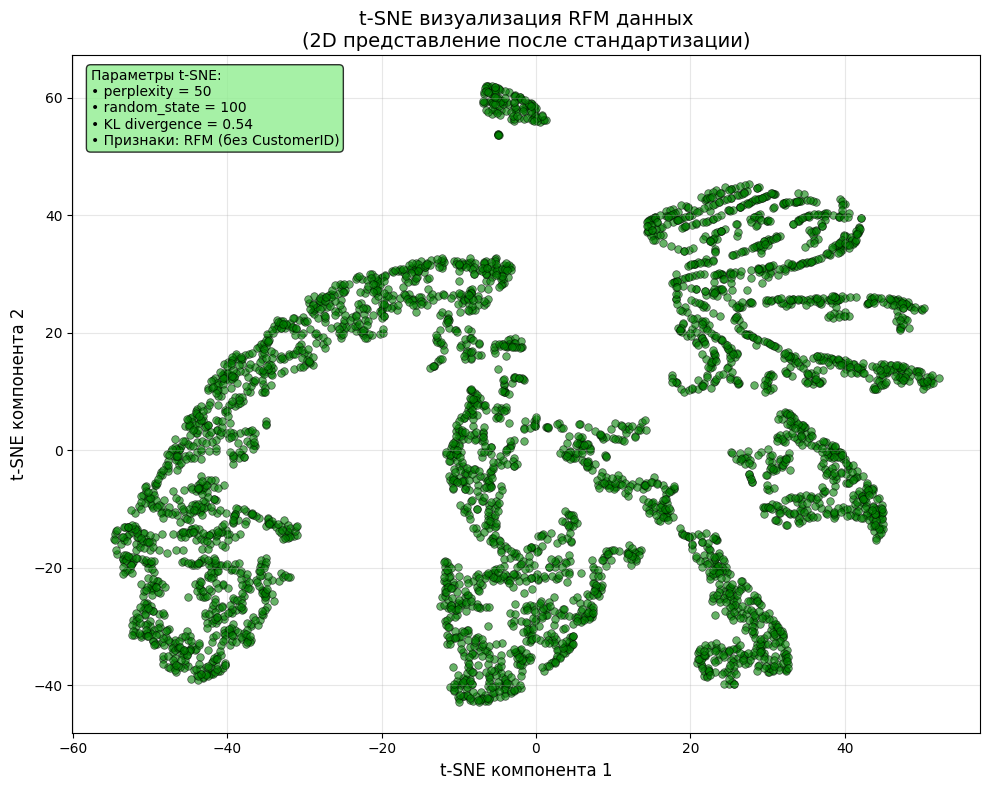

In [97]:
# Создание pipeline и обучение t-SNE
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

# Создаем pipeline с стандартизацией и t-SNE
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация с параметрами по умолчанию
    ('tsne', TSNE(n_components=2,    # Двумерное представление
                  perplexity=50,      # Параметр perplexity
                  random_state=100))  # Фиксация random_state
])

# Обучение и трансформация
rfm_tsne_transformed = tsne_pipeline.fit_transform(rfm_for_tsne)

print("Первые 5 строк преобразованных данных:")
print(rfm_tsne_transformed[:5])

# Получение дивергенции Кульбака-Лейблера
tsne_model = tsne_pipeline.named_steps['tsne']
kl_divergence = tsne_model.kl_divergence_

print(f"Дивергенция Кульбака-Лейблера: {kl_divergence}")

# Обновляем основную переменную для дальнейшего использования
rfm_table_filtered = rfm_for_tsne


# Визуализация результатов t-SNE

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(rfm_tsne_transformed[:, 0], rfm_tsne_transformed[:, 1], 
           alpha=0.6, s=30, c='green', edgecolors='black', linewidth=0.5)
plt.title('t-SNE визуализация RFM данных\n(2D представление после стандартизации)', fontsize=14)
plt.xlabel('t-SNE компонента 1', fontsize=12)
plt.ylabel('t-SNE компонента 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Добавим информацию о параметрах
plt.text(0.02, 0.98, f'Параметры t-SNE:\n• perplexity = 50\n• random_state = 100\n• KL divergence = {kl_divergence:.2f}\n• Признаки: RFM (без CustomerID)', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



k =  3: Коэффициент силуэта = 0.4279
k =  4: Коэффициент силуэта = 0.4784
k =  5: Коэффициент силуэта = 0.4508
k =  6: Коэффициент силуэта = 0.4542
k =  7: Коэффициент силуэта = 0.4667
k =  8: Коэффициент силуэта = 0.4999
   • Оптимальное количество кластеров: 8
   • Максимальное значение коэффициента силуэта: 0.4999


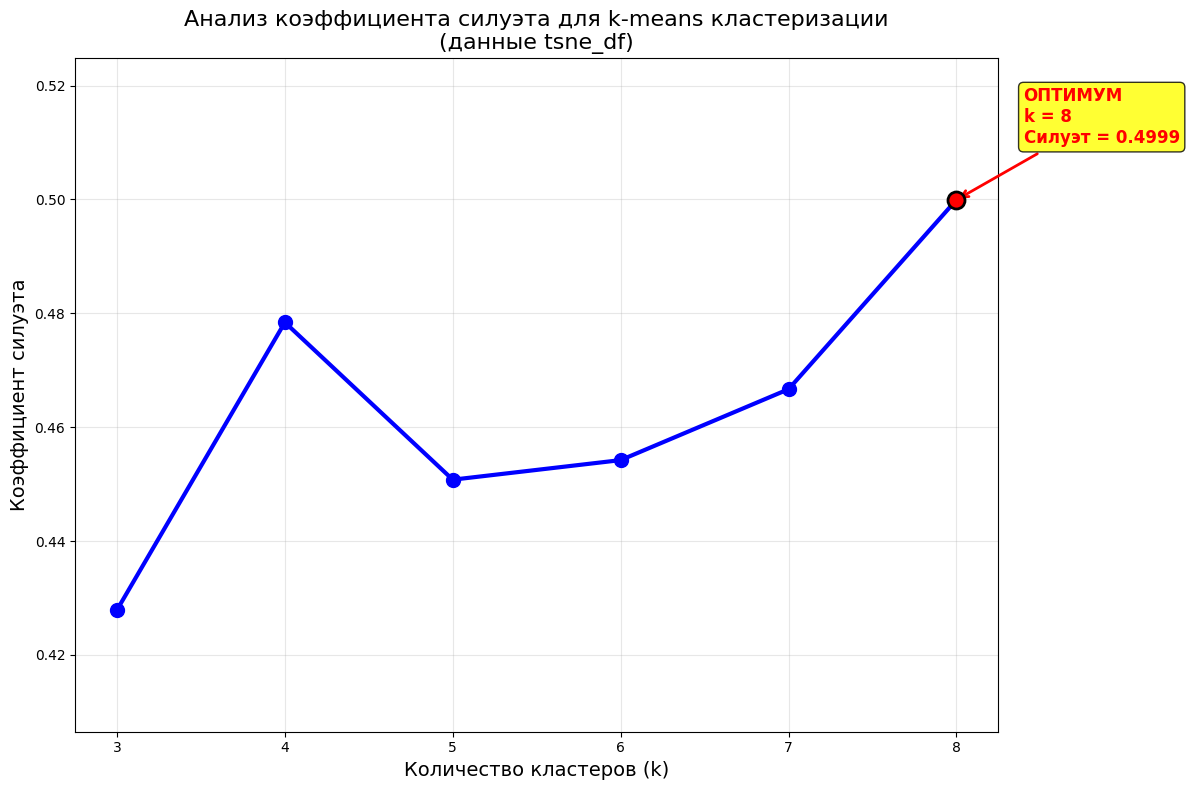

In [100]:
# Задание 6.2: Подбор оптимального количества кластеров для k-means
# Используем данные tsne_df (2D координаты после t-SNE преобразования)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Конвертируем numpy array в DataFrame для seaborn
tsne_df = pd.DataFrame(rfm_tsne_transformed, columns=['axis-1', 'axis-2'])

# Перебираем количество кластеров от 3 до 8
k_range = range(3, 9)
silhouette_scores = []

# Анализ оптимального количества кластеров для k-means на tsne_df:
for k in k_range:
    # Применяем k-means с заданными параметрами к данным tsne_df
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_df)
    
    # Вычисляем коэффициент силуэта для данных tsne_df
    silhouette_avg = silhouette_score(tsne_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"k = {k:2d}: Коэффициент силуэта = {silhouette_avg:.4f}")

# Находим оптимальное количество кластеров
optimal_k = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)

print(f"   • Оптимальное количество кластеров: {optimal_k}")
print(f"   • Максимальное значение коэффициента силуэта: {max_silhouette:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 8))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=3, markersize=10)
plt.xlabel('Количество кластеров (k)', fontsize=14)
plt.ylabel('Коэффициент силуэта', fontsize=14)
plt.title('Анализ коэффициента силуэта для k-means кластеризации\n(данные tsne_df)', fontsize=16)
plt.grid(True, alpha=0.3)

# Выделяем оптимальную точку
plt.scatter(optimal_k, max_silhouette, color='red', s=150, zorder=5, edgecolor='black', linewidth=2)
plt.annotate(f'ОПТИМУМ\nk = {optimal_k}\nСилуэт = {max_silhouette:.4f}', 
             xy=(optimal_k, max_silhouette), xytext=(optimal_k+0.4, max_silhouette+0.01),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=12, color='red', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

plt.xticks(k_range)
plt.ylim(bottom=min(silhouette_scores)*0.95, top=max(silhouette_scores)*1.05)
plt.tight_layout()
plt.show()

k = 7: Силуэт = 0.4667
k = 8: Силуэт = 0.4999


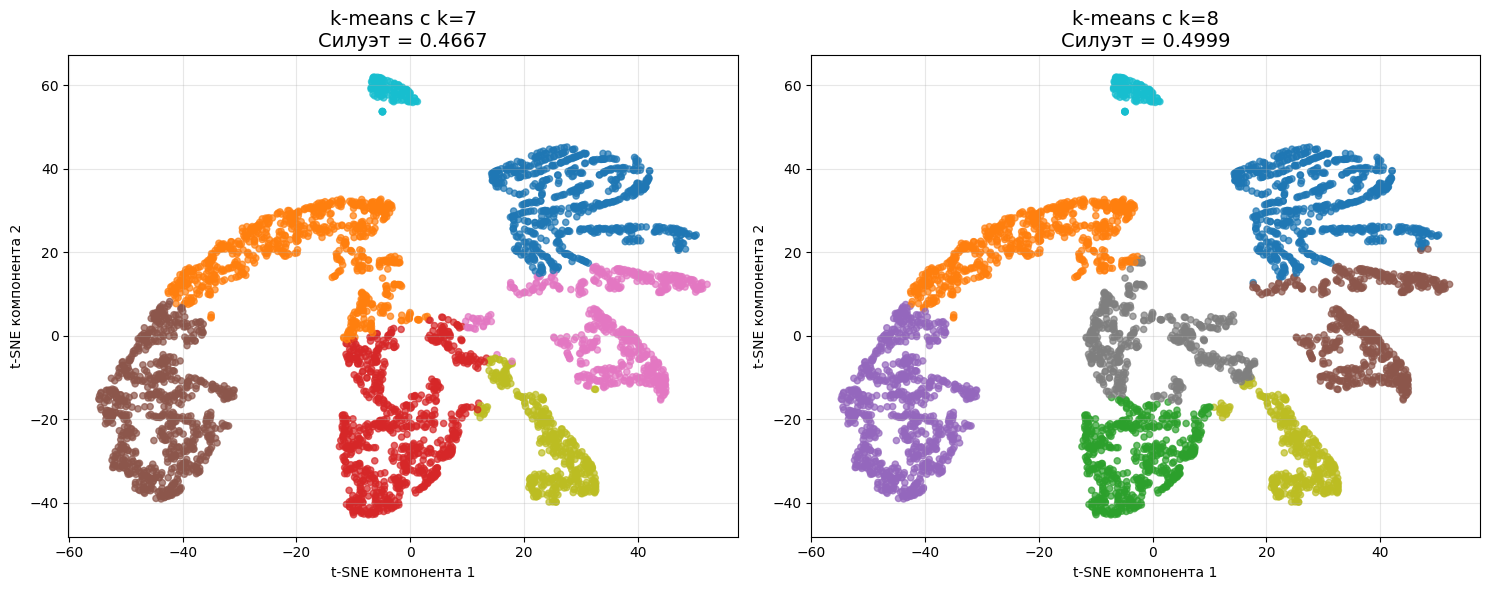

In [101]:
# Дополнительный анализ: проверим качество кластеризации с k=7 vs k=8

# Проверим k=7
kmeans_7 = KMeans(n_clusters=7, random_state=42)
labels_7 = kmeans_7.fit_predict(tsne_df)
silhouette_7 = silhouette_score(tsne_df, labels_7)

print(f"k = 7: Силуэт = {silhouette_7:.4f}")

# Проверим k=8
kmeans_8 = KMeans(n_clusters=8, random_state=42)
labels_8 = kmeans_8.fit_predict(tsne_df)
silhouette_8 = silhouette_score(tsne_df, labels_8)

print(f"k = 8: Силуэт = {silhouette_8:.4f}")

# Визуализация кластеров для k=7 и k=8
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# k=7
scatter1 = ax1.scatter(tsne_df['axis-1'], tsne_df['axis-2'], c=labels_7, 
                      cmap='tab10', alpha=0.7, s=20)
ax1.set_title(f'k-means с k=7\nСилуэт = {silhouette_7:.4f}', fontsize=14)
ax1.set_xlabel('t-SNE компонента 1')
ax1.set_ylabel('t-SNE компонента 2')
ax1.grid(True, alpha=0.3)

# k=8
scatter2 = ax2.scatter(tsne_df['axis-1'], tsne_df['axis-2'], c=labels_8, 
                      cmap='tab10', alpha=0.7, s=20)
ax2.set_title(f'k-means с k=8\nСилуэт = {silhouette_8:.4f}', fontsize=14)
ax2.set_xlabel('t-SNE компонента 1')
ax2.set_ylabel('t-SNE компонента 2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

k =  3: Коэффициент силуэта = 0.4260
k =  4: Коэффициент силуэта = 0.4692
k =  5: Коэффициент силуэта = 0.3749
k =  6: Коэффициент силуэта = 0.3463
k =  7: Коэффициент силуэта = 0.4272
k =  8: Коэффициент силуэта = 0.4869
РЕЗУЛЬТАТЫ для EM-алгоритма (GaussianMixture):
   • Оптимальное количество кластеров: 8
   • Максимальное значение коэффициента силуэта: 0.4869
   • Ответ (округлено до 2 знаков): 0.49


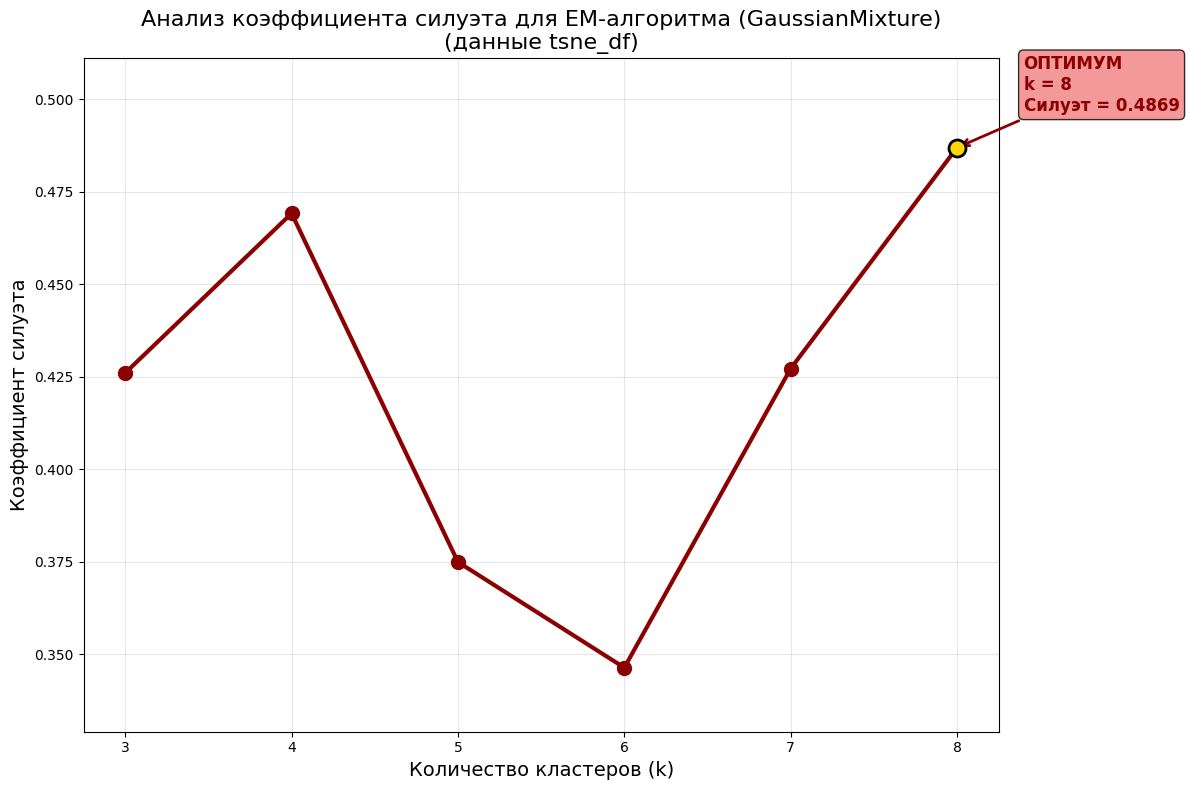

In [102]:
# Задание 6.3: Подбор оптимального количества кластеров для EM-алгоритма (GaussianMixture)
# Используем данные tsne_df (2D координаты после t-SNE преобразования)

# Перебираем количество кластеров от 3 до 8
k_range_em = range(3, 9)
silhouette_scores_em = []


for k in k_range_em:
    # Применяем GaussianMixture с заданными параметрами к данным tsne_df
    gmm = GaussianMixture(n_components=k, random_state=42)
    cluster_labels_em = gmm.fit_predict(tsne_df)
    
    # Вычисляем коэффициент силуэта для данных tsne_df
    silhouette_avg_em = silhouette_score(tsne_df, cluster_labels_em)
    silhouette_scores_em.append(silhouette_avg_em)
    
    print(f"k = {k:2d}: Коэффициент силуэта = {silhouette_avg_em:.4f}")

# Находим оптимальное количество кластеров
optimal_k_em = k_range_em[np.argmax(silhouette_scores_em)]
max_silhouette_score_em = max(silhouette_scores_em)

print(f"РЕЗУЛЬТАТЫ для EM-алгоритма (GaussianMixture):")
print(f"   • Оптимальное количество кластеров: {optimal_k_em}")
print(f"   • Максимальное значение коэффициента силуэта: {max_silhouette_score_em:.4f}")
print(f"   • Ответ (округлено до 2 знаков): {round(max_silhouette_score_em, 2)}")

# Визуализация результатов
plt.figure(figsize=(12, 8))
plt.plot(k_range_em, silhouette_scores_em, 'ro-', linewidth=3, markersize=10, color='darkred')
plt.xlabel('Количество кластеров (k)', fontsize=14)
plt.ylabel('Коэффициент силуэта', fontsize=14)
plt.title('Анализ коэффициента силуэта для EM-алгоритма (GaussianMixture)\n(данные tsne_df)', fontsize=16)
plt.grid(True, alpha=0.3)

# Выделяем оптимальную точку
plt.scatter(optimal_k_em, max_silhouette_score_em, color='gold', s=150, zorder=5, edgecolor='black', linewidth=2)
plt.annotate(f'ОПТИМУМ\nk = {optimal_k_em}\nСилуэт = {max_silhouette_score_em:.4f}', 
             xy=(optimal_k_em, max_silhouette_score_em), xytext=(optimal_k_em+0.4, max_silhouette_score_em+0.01),
             arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
             fontsize=12, color='darkred', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8))

plt.xticks(k_range_em)
plt.ylim(bottom=min(silhouette_scores_em)*0.95, top=max(silhouette_scores_em)*1.05)
plt.tight_layout()
plt.show()

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



k =  2: Коэффициент силуэта = 0.3793
k =  3: Коэффициент силуэта = 0.4100
k =  4: Коэффициент силуэта = 0.4556
k =  5: Коэффициент силуэта = 0.4257
k =  6: Коэффициент силуэта = 0.4114
k =  7: Коэффициент силуэта = 0.4216
k =  8: Коэффициент силуэта = 0.4491
РЕЗУЛЬТАТЫ для агломеративной кластеризации:
   • Оптимальное количество кластеров: 4
   • Максимальное значение коэффициента силуэта: 0.4556
   • Ответ (округлено до 2 знаков): 0.46


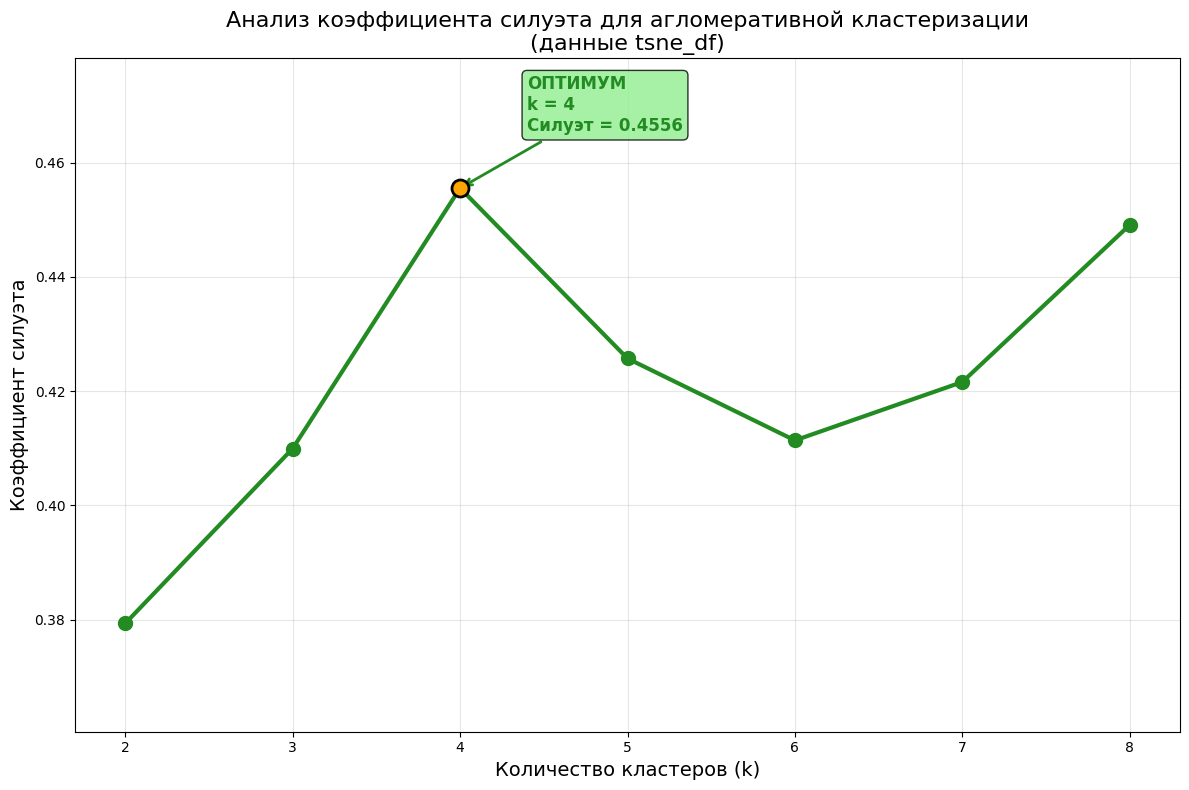

In [105]:
# Задание 6.4: Подбор оптимального количества кластеров для агломеративной кластеризации
# Используем данные tsne_df (2D координаты после t-SNE преобразования)

from sklearn.cluster import AgglomerativeClustering

# Перебираем количество кластеров от 2 до 8 (как указано в задании)
k_range_agg = range(2, 9)
silhouette_scores_agg = []


for k in k_range_agg:
    # Применяем AgglomerativeClustering с заданными параметрами к данным tsne_df
    # Все параметры по умолчанию, кроме n_clusters
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    cluster_labels_agg = agg_clustering.fit_predict(tsne_df)
    
    # Вычисляем коэффициент силуэта для данных tsne_df
    silhouette_avg_agg = silhouette_score(tsne_df, cluster_labels_agg)
    silhouette_scores_agg.append(silhouette_avg_agg)
    
    print(f"k = {k:2d}: Коэффициент силуэта = {silhouette_avg_agg:.4f}")

# Находим оптимальное количество кластеров
optimal_k_agg = k_range_agg[np.argmax(silhouette_scores_agg)]
max_silhouette_score_agg = max(silhouette_scores_agg)

print(f"РЕЗУЛЬТАТЫ для агломеративной кластеризации:")
print(f"   • Оптимальное количество кластеров: {optimal_k_agg}")
print(f"   • Максимальное значение коэффициента силуэта: {max_silhouette_score_agg:.4f}")
print(f"   • Ответ (округлено до 2 знаков): {round(max_silhouette_score_agg, 2)}")

# Визуализация результатов
plt.figure(figsize=(12, 8))
plt.plot(k_range_agg, silhouette_scores_agg, 'go-', linewidth=3, markersize=10, color='forestgreen')
plt.xlabel('Количество кластеров (k)', fontsize=14)
plt.ylabel('Коэффициент силуэта', fontsize=14)
plt.title('Анализ коэффициента силуэта для агломеративной кластеризации\n(данные tsne_df)', fontsize=16)
plt.grid(True, alpha=0.3)

# Выделяем оптимальную точку
plt.scatter(optimal_k_agg, max_silhouette_score_agg, color='orange', s=150, zorder=5, edgecolor='black', linewidth=2)
plt.annotate(f'ОПТИМУМ\nk = {optimal_k_agg}\nСилуэт = {max_silhouette_score_agg:.4f}', 
             xy=(optimal_k_agg, max_silhouette_score_agg), xytext=(optimal_k_agg+0.4, max_silhouette_score_agg+0.01),
             arrowprops=dict(arrowstyle='->', color='forestgreen', lw=2),
             fontsize=12, color='forestgreen', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

plt.xticks(k_range_agg)
plt.ylim(bottom=min(silhouette_scores_agg)*0.95, top=max(silhouette_scores_agg)*1.05)
plt.tight_layout()
plt.show()



### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [106]:
# 🎯 K-means кластеризация с k=7 кластерами
print("K-means кластеризация с k=7 кластерами")

# Создаем и обучаем модель K-means с k=7
kmeans_7_clusters = KMeans(n_clusters=7, random_state=42, n_init=10)
cluster_labels_7 = kmeans_7_clusters.fit_predict(tsne_df)

# Анализируем распределение кластеров
from collections import Counter
cluster_counts_7 = Counter(cluster_labels_7)

for cluster_id in sorted(cluster_counts_7.keys()):
    cluster_size = cluster_counts_7[cluster_id]
    percentage = (cluster_size / len(tsne_df)) * 100
    print(f"Кластер {cluster_id}: {cluster_size:5d} клиентов ({percentage:5.1f}%)")

# Находим самый большой кластер
largest_cluster_id_7 = max(cluster_counts_7, key=cluster_counts_7.get)
largest_cluster_size_7 = cluster_counts_7[largest_cluster_id_7]
largest_cluster_percent_7 = (largest_cluster_size_7 / len(tsne_df)) * 100


print(f" РЕЗУЛЬТАТ:")
print(f"   Самый большой кластер: {largest_cluster_id_7}")
print(f"   Количество клиентов в самом большом кластере: {largest_cluster_size_7}")
print(f"   Процент от общего количества клиентов: {largest_cluster_percent_7:.1f}%")

K-means кластеризация с k=7 кластерами
Кластер 0:   914 клиентов ( 22.6%)
Кластер 1:   543 клиентов ( 13.4%)
Кластер 2:   656 клиентов ( 16.2%)
Кластер 3:   446 клиентов ( 11.0%)
Кластер 4:   683 клиентов ( 16.9%)
Кластер 5:   397 клиентов (  9.8%)
Кластер 6:   405 клиентов ( 10.0%)
 РЕЗУЛЬТАТ:
   Самый большой кластер: 0
   Количество клиентов в самом большом кластере: 914
   Процент от общего количества клиентов: 22.6%


Визуализируем результаты кластеризации:

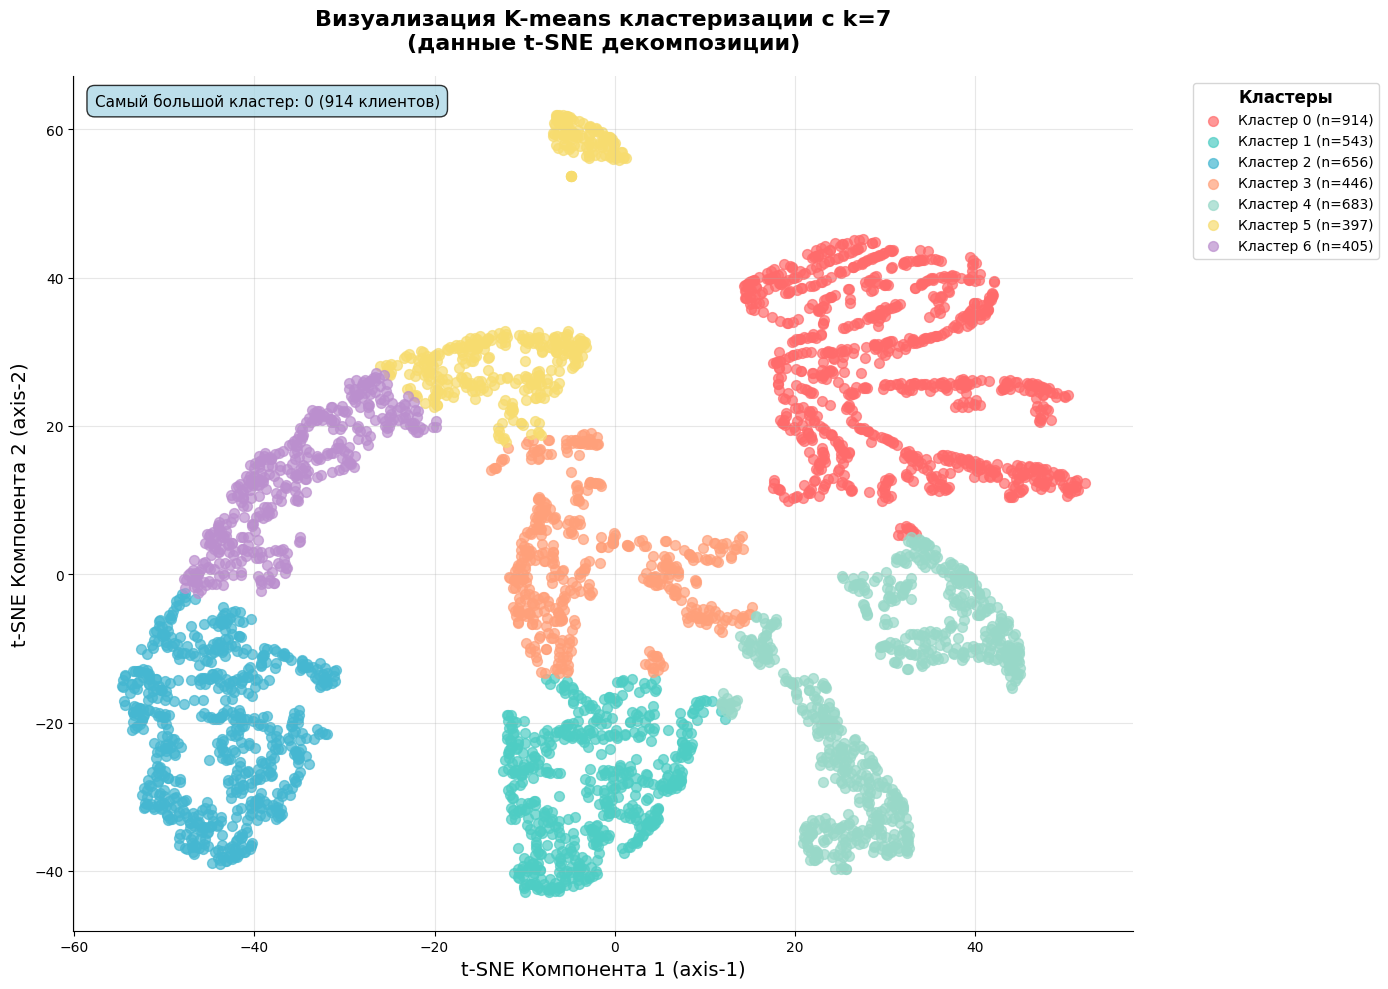


Статистика по кластерам:
---------------------------------------------
🔴 Кластер 0: 914 клиентов (22.6%) - центр: (31.21, 27.01)
⚫ Кластер 1: 543 клиентов (13.4%) - центр: (-2.75, -28.62)
⚫ Кластер 2: 656 клиентов (16.2%) - центр: (-43.99, -21.27)
⚫ Кластер 3: 446 клиентов (11.0%) - центр: (-2.11, 1.28)
⚫ Кластер 4: 683 клиентов (16.9%) - центр: (30.01, -16.64)
⚫ Кластер 5: 397 клиентов ( 9.8%) - центр: (-10.35, 36.59)
⚫ Кластер 6: 405 клиентов (10.0%) - центр: (-35.54, 12.72)


In [109]:
# Создаем цветовую палитру для 7 кластеров
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']
cluster_names = [f'Кластер {i}' for i in range(7)]

# Создаем фигуру с увеличенным размером
plt.figure(figsize=(14, 10))

# Создаем scatter plot для каждого кластера
for i in range(7):
    cluster_data = tsne_df[cluster_labels_7 == i]
    cluster_size = len(cluster_data)
    
    plt.scatter(cluster_data['axis-1'], cluster_data['axis-2'], 
               c=colors[i], alpha=0.7, s=50,
               label=f'{cluster_names[i]} (n={cluster_size})')

# Настройка графика
plt.title('Визуализация K-means кластеризации с k=7\n(данные t-SNE декомпозиции)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('t-SNE Компонента 1 (axis-1)', fontsize=14)
plt.ylabel('t-SNE Компонента 2 (axis-2)', fontsize=14)

# Добавляем легенду
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
legend.set_title('Кластеры', prop={'size': 12, 'weight': 'bold'})

# Добавляем сетку для лучшей читаемости
plt.grid(True, alpha=0.3)

# Настройка осей
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Добавляем информацию о самом большом кластере
plt.text(0.02, 0.98, f'Самый большой кластер: {largest_cluster_id_7} ({largest_cluster_size_7} клиентов)', 
         transform=plt.gca().transAxes, fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='top')

# Улучшение макета
plt.tight_layout()
plt.show()

# Дополнительная статистика по кластерам
print(f"\nСтатистика по кластерам:")
print("-" * 45)
for i in range(7):
    cluster_data = tsne_df[cluster_labels_7 == i]
    size = len(cluster_data)
    percentage = (size / len(tsne_df)) * 100
    
    center_x = cluster_data['axis-1'].mean()
    center_y = cluster_data['axis-2'].mean()
    
    marker = "🔴" if i == largest_cluster_id_7 else "⚫"
    print(f"{marker} Кластер {i}: {size:3d} клиентов ({percentage:4.1f}%) - центр: ({center_x:.2f}, {center_y:.2f})")



Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [117]:
# Используем результаты кластеризации k-means с k=7

# Получаем кластеры от k-means с k=7
k7_cluster_labels = cluster_labels_7

# Создаем копию RFM таблицы и добавляем метки кластеров k=7
rfm_with_clusters_k7 = rfm_table_filtered.copy()
rfm_with_clusters_k7['Cluster'] = k7_cluster_labels

print(f"\n RFM таблица с кластерами k=7:")
print(f"   • Размер: {rfm_with_clusters_k7.shape}")
print(f"   • Столбцы: {list(rfm_with_clusters_k7.columns)}")

# Группируем по кластерам и считаем средние значения
cluster_profiles_k7 = rfm_with_clusters_k7.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean()

# Округляем все значения до целого числа
cluster_profiles_k7_rounded = cluster_profiles_k7.round(0).astype(int)

print(f"\n Профили кластеров k=7 (средние значения, округленные до целого):")
print(cluster_profiles_k7_rounded)



 RFM таблица с кластерами k=7:
   • Размер: (4044, 4)
   • Столбцы: ['Recency', 'Frequency', 'MonetaryValue', 'Cluster']

 Профили кластеров k=7 (средние значения, округленные до целого):
         Recency  Frequency  MonetaryValue
Cluster                                   
0             32          7           2417
1             40          2            614
2             46          1            322
3            196          2            670
4             40          3            995
5            313          1            261
6            181          1            273


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



Профили кластеров для k=7:
         Recency  Frequency  MonetaryValue
Cluster                                   
0             32          7           2417
1             40          2            614
2             46          1            322
3            196          2            670
4             40          3            995
5            313          1            261
6            181          1            273

Нормализованные данные для полярной диаграммы:
         Recency  Frequency  MonetaryValue
Cluster                                   
0          1.000      1.000          1.000
1          0.973      0.170          0.164
2          0.950      0.000          0.028
3          0.418      0.250          0.190
4          0.972      0.425          0.341
5          0.000      0.002          0.000
6          0.469      0.000          0.006



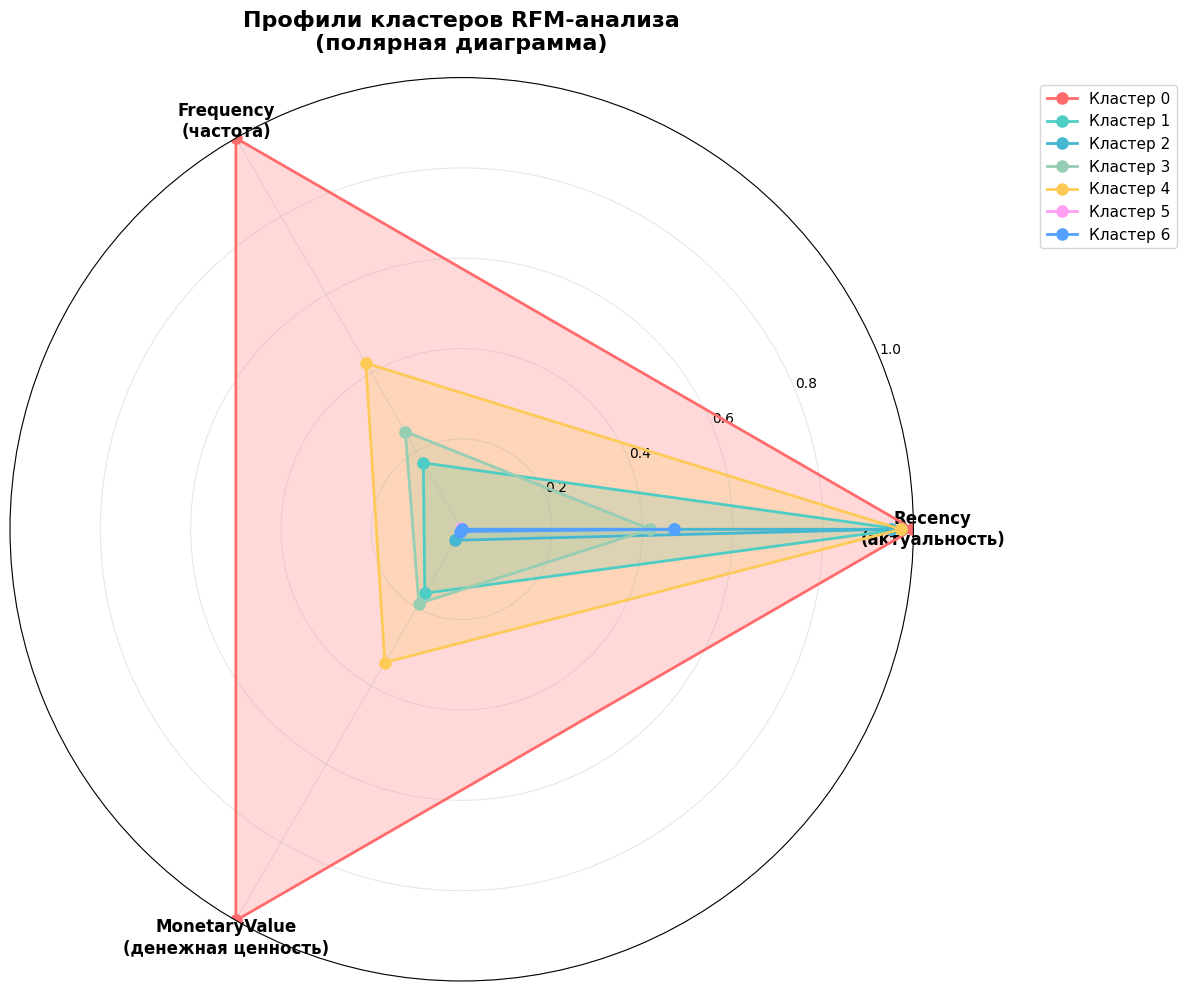

In [119]:
# Получим профили кластеров для k=7 (уже созданы ранее)
from sklearn.preprocessing import MinMaxScaler

print("Профили кластеров для k=7:")
print(cluster_profiles_k7_rounded)
print()

# Подготавливаем данные для полярной диаграммы
# Для полярной диаграммы нужно учесть, что:
# - Recency: меньше = лучше (инвертируем)
# - Frequency: больше = лучше
# - MonetaryValue: больше = лучше

# Создаем нормализованные данные для визуализации
cluster_data_for_radar = cluster_profiles_k7.copy()

# Инвертируем Recency (чтобы меньше значений было лучше на диаграмме)
max_recency = cluster_data_for_radar['Recency'].max()
cluster_data_for_radar['Recency_inverted'] = max_recency - cluster_data_for_radar['Recency']

# Нормализуем все метрики к диапазону 0-1 для красивой визуализации
scaler_radar = MinMaxScaler()
radar_data = pd.DataFrame()
radar_data['Recency'] = scaler_radar.fit_transform(cluster_data_for_radar[['Recency_inverted']]).flatten()
radar_data['Frequency'] = scaler_radar.fit_transform(cluster_data_for_radar[['Frequency']]).flatten()
radar_data['MonetaryValue'] = scaler_radar.fit_transform(cluster_data_for_radar[['MonetaryValue']]).flatten()
radar_data.index = cluster_data_for_radar.index

print("Нормализованные данные для полярной диаграммы:")
print(radar_data.round(3))
print()

# Создаем полярную диаграмму
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Угловые позиции для метрик
angles = np.linspace(0, 2 * np.pi, len(radar_data.columns), endpoint=False).tolist()
angles += angles[:1]  # замыкаем круг

# Цвета для каждого кластера
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF']

# Рисуем каждый кластер
for i, cluster in enumerate(radar_data.index):
    values = radar_data.loc[cluster].values.tolist()
    values += values[:1]  # замыкаем линию
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Кластер {cluster}', 
            color=colors[i], markersize=8)
    ax.fill(angles, values, alpha=0.25, color=colors[i])

# Настройка диаграммы
ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Recency\n(актуальность)', 'Frequency\n(частота)', 'MonetaryValue\n(денежная ценность)'], 
                   fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.3)

plt.title('Профили кластеров RFM-анализа\n(полярная диаграмма)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
plt.tight_layout()
plt.show()

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [121]:
# Импортируем необходимые библиотеки для машинного обучения
from sklearn.model_selection import train_test_split

# Для задачи машинного обучения используем RFM данные как признаки (X) 
# и кластерные метки как целевую переменную (y)
X = rfm_table_filtered.copy()  # Признаки: RFM характеристики
y = cluster_labels_7.copy()  # Целевая переменная: кластерные метки

print(f"Распределение по кластерам:")
unique, counts = np.unique(y, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Кластер {cluster}: {count} клиентов")

print(f"\nОбщее количество клиентов: {len(X)}")

# Разделяем данные на тренировочную и тестовую выборки в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% для тестирования
    random_state=42,   # Фиксируем генератор случайных чисел
    stratify=y         # Сохраняем пропорции классов в обеих выборках
)

print(f"Тренировочная выборка:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")

print(f"\nТестовая выборка:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

# Количество клиентов в тестовой выборке
test_clients_count = len(X_test)
print(f"\nКоличество клиентов в тестовой выборке: {test_clients_count}")


Распределение по кластерам:
  Кластер 0: 914 клиентов
  Кластер 1: 543 клиентов
  Кластер 2: 656 клиентов
  Кластер 3: 446 клиентов
  Кластер 4: 683 клиентов
  Кластер 5: 397 клиентов
  Кластер 6: 405 клиентов

Общее количество клиентов: 4044
Тренировочная выборка:
  X_train: (3235, 3)
  y_train: (3235,)

Тестовая выборка:
  X_test: (809, 3)
  y_test: (809,)

Количество клиентов в тестовой выборке: 809


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [122]:
# Импортируем необходимые библиотеки
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Определяем сетку параметров для RandomForest
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Создаем RandomForest с random_state=42
rf = RandomForestClassifier(random_state=42)

# Создаем GridSearchCV
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Обучаем GridSearchCV на тренировочных данных
print("Обучение GridSearchCV для RandomForest...")
grid_search.fit(X_train, y_train)

# Получаем лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший score: {grid_search.best_score_:.4f}")

# Ответ на первый вопрос - оптимальная максимальная глубина
optimal_max_depth = grid_search.best_params_['max_depth']
print(f"\n1) Оптимальная максимальная глубина деревьев: {optimal_max_depth}")

# Делаем предсказания на тестовой выборке
y_pred = grid_search.best_estimator_.predict(X_test)

# Рассчитываем accuracy на тестовой выборке
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n2) Accuracy на тестовой выборке: {test_accuracy:.3f}")

# Сохраняем лучшую модель для дальнейшего использования
best_rf_model = grid_search.best_estimator_

Обучение GridSearchCV для RandomForest...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 100}
Лучший score: 0.9889

1) Оптимальная максимальная глубина деревьев: 14

2) Accuracy на тестовой выборке: 0.981


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [123]:
# Импортируем GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Определяем сетку параметров для GradientBoosting
param_grid_gb = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Создаем GradientBoostingClassifier с random_state=42
gb = GradientBoostingClassifier(random_state=42)

# Создаем GridSearchCV для градиентного бустинга
grid_search_gb = GridSearchCV(
    gb, 
    param_grid_gb, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Обучаем GridSearchCV на тренировочных данных
print("Обучение GridSearchCV для GradientBoosting...")
grid_search_gb.fit(X_train, y_train)

# Получаем лучшие параметры
print(f"Лучшие параметры: {grid_search_gb.best_params_}")
print(f"Лучший score: {grid_search_gb.best_score_:.4f}")

# Ответ на первый вопрос - оптимальная максимальная глубина
optimal_max_depth_gb = grid_search_gb.best_params_['max_depth']
print(f"\n1) Оптимальная максимальная глубина деревьев в градиентном бустинге: {optimal_max_depth_gb}")

# Делаем предсказания на тестовой выборке
y_pred_gb = grid_search_gb.best_estimator_.predict(X_test)

# Рассчитываем accuracy на тестовой выборке
test_accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"\n2) Accuracy на тестовой выборке: {test_accuracy_gb:.3f}")

# Сохраняем лучшую модель для дальнейшего использования
best_gb_model = grid_search_gb.best_estimator_

Обучение GridSearchCV для GradientBoosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Лучший score: 0.9876

1) Оптимальная максимальная глубина деревьев в градиентном бустинге: 6

2) Accuracy на тестовой выборке: 0.983


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

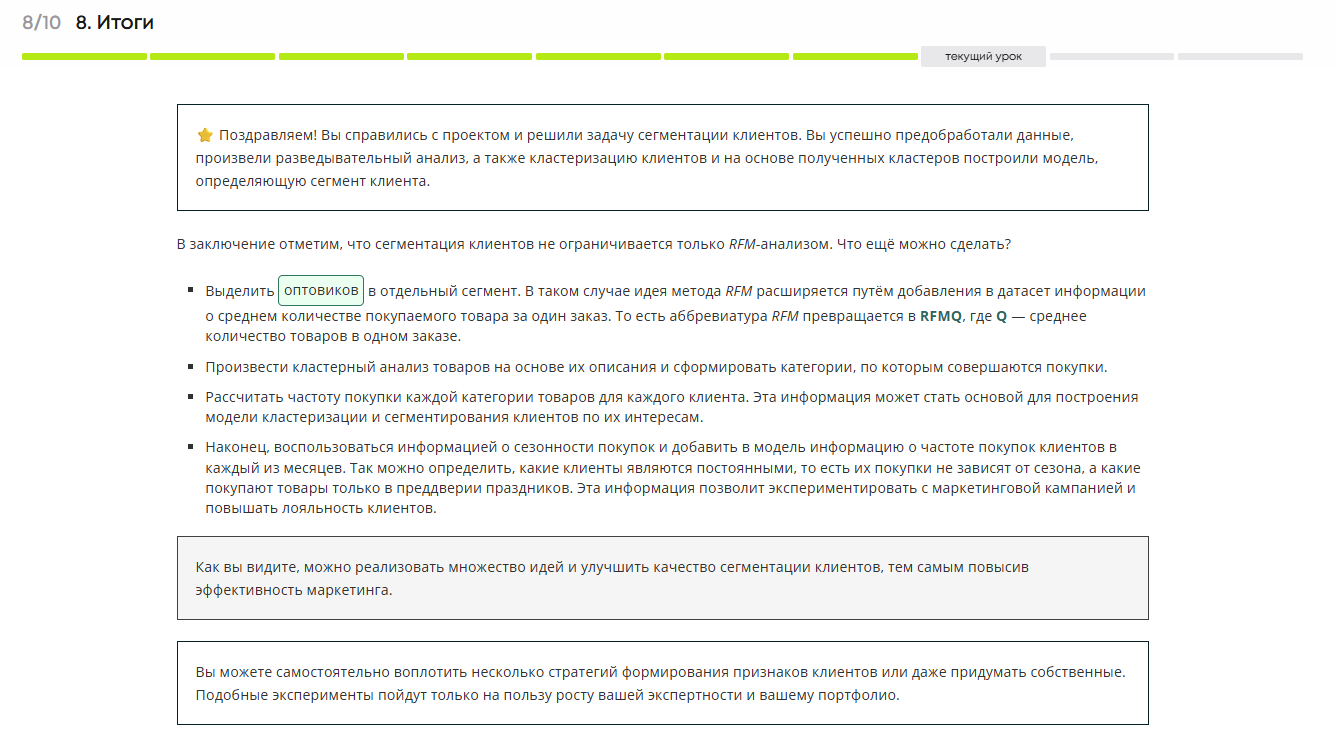